In [1]:
import sklearn as sk
import numpy as np
import torch
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
matplotlib.rc("font",family='YouYuan')

# 数据准备

In [2]:
ML_ready=pd.read_csv(".\\ML_ready.csv")
ML_ready['planet_to_star_radius'] = ML_ready['planet_radius'] / ML_ready['star_radius']
ML_ready['star_density'] = ML_ready['star_mass'] / (ML_ready['star_radius'] ** 3)
ML_ready['j_minus_k'] = ML_ready['j_mag'] - ML_ready['k_mag']
ML_ready['h_minus_k'] = ML_ready['h_mag'] - ML_ready['k_mag']
#ML_ready['log_planet_radius'] = np.log1p(ML_ready['planet_radius'])
#ML_ready['log_orbital_period'] = np.log1p(ML_ready['orbital_period'])
#ML_ready['log_star_mass'] = np.log1p(ML_ready['star_mass'])
ML_ready['radius_times_period'] = ML_ready['planet_radius'] * ML_ready['orbital_period']
ML_ready['radius_over_mass'] = ML_ready['planet_radius'] / ML_ready['star_mass']
# 去除高度共线性的变量
ML_ready=ML_ready.drop('k_mag',axis=1)
ML_ready=ML_ready.drop('h_mag',axis=1)
ML_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19761 entries, 0 to 19760
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PC1                    19761 non-null  float64
 1   PC2                    19761 non-null  float64
 2   PC3                    19761 non-null  float64
 3   label                  19761 non-null  int64  
 4   ra                     19761 non-null  float64
 5   dec                    19761 non-null  float64
 6   j_mag                  19761 non-null  float64
 7   kep_mag                19761 non-null  float64
 8   planet_radius          19761 non-null  float64
 9   orbital_period         19761 non-null  float64
 10  star_teff              19761 non-null  float64
 11  star_logg              19761 non-null  float64
 12  star_radius            19761 non-null  float64
 13  star_mass              19761 non-null  float64
 14  lc_time0               19761 non-null  float64
 15  pl

In [3]:
ML_ready.info()
ML_ready.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19761 entries, 0 to 19760
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PC1                    19761 non-null  float64
 1   PC2                    19761 non-null  float64
 2   PC3                    19761 non-null  float64
 3   label                  19761 non-null  int64  
 4   ra                     19761 non-null  float64
 5   dec                    19761 non-null  float64
 6   j_mag                  19761 non-null  float64
 7   kep_mag                19761 non-null  float64
 8   planet_radius          19761 non-null  float64
 9   orbital_period         19761 non-null  float64
 10  star_teff              19761 non-null  float64
 11  star_logg              19761 non-null  float64
 12  star_radius            19761 non-null  float64
 13  star_mass              19761 non-null  float64
 14  lc_time0               19761 non-null  float64
 15  pl

,PC1,PC2,PC3,label,ra,dec,j_mag,kep_mag,planet_radius,orbital_period,...,star_logg,star_radius,star_mass,lc_time0,planet_to_star_radius,star_density,j_minus_k,h_minus_k,radius_times_period,radius_over_mass
0,-0.329993,-0.469118,-0.051703,2,297.00482,48.134129,14.254,15.436,14.60,19.899140,...,4.544,0.868,0.961,175.850252,16.820276,1.469482,0.428,0.074,290.527443,15.192508
1,0.093289,-0.453369,0.408759,2,285.53461,48.285210,14.326,15.597,33.46,1.736952,...,4.564,0.791,0.836,170.307565,42.300885,1.689183,0.517,0.102,58.118429,40.023923
2,-0.469821,-0.455314,0.015327,0,288.75488,48.226200,14.366,15.509,2.75,2.525592,...,4.438,1.046,1.095,171.595550,2.629063,0.956795,0.414,0.112,6.945377,2.511416
3,-0.296522,0.062012,0.022569,0,296.28613,48.224670,14.528,15.714,3.90,11.094321,...,4.486,0.972,1.053,171.201160,4.012346,1.146647,0.396,-0.019,43.267850,3.703704
4,-0.399275,-0.189558,0.008973,0,296.28613,48.224670,14.528,15.714,2.77,4.134435,...,4.486,0.972,1.053,172.979370,2.849794,1.146647,0.396,-0.019,11.452385,2.630579


In [4]:
numeric_features = ['PC1', 'PC2', 'PC3', 'j_mag', 'kep_mag', 
                   'planet_radius', 'orbital_period', 'star_teff', 'star_logg', 
                   'star_radius', 'star_mass', 'lc_time0','planet_to_star_radius','star_density',
                   'j_minus_k','h_minus_k','radius_times_period','radius_over_mass']
# 检查是否需要标准化
print("特征值范围检查：")

feature_ranges = ML_ready[numeric_features].agg(['min', 'max', 'std'])
print(feature_ranges)

# 检查数据平衡性
class_balance = ML_ready['label'].value_counts(normalize=True)
print(f"\n类别平衡性：")
print(class_balance)

if class_balance.min() < 0.1:  # 如果最小类别占比小于10%
    print("警告：数据可能存在类别不平衡问题")

特征值范围检查：
           PC1        PC2       PC3      j_mag    kep_mag  planet_radius  \
min  -0.591683  -2.864373 -7.777481   4.097000   4.627800       0.036257   
max  13.803377  24.012589  7.424680  17.372000  20.003000   26042.900000   
std   1.024262   0.799844  0.503856   1.232746   1.964285     198.858223   

     orbital_period     star_teff  star_logg  star_radius  star_mass  \
min        0.152076   2520.000000   0.047000     0.109000   0.000000   
max    83830.000000  50000.000000   5.960650   229.908000  14.336000   
std      606.676580   1165.439181   0.345673     4.335476   0.261247   

         lc_time0  planet_to_star_radius  star_density  j_minus_k  h_minus_k  \
min  1.205659e+02               0.054041      0.000000  -0.744000  -1.834000   
max  2.460863e+06            2693.164426    716.754320   5.137000   2.942000   
std  1.208171e+06              47.709361     15.009019   0.154479   0.069509   

     radius_times_period  radius_over_mass  
min             0.009825       

In [8]:
infinite_mask = np.isinf(ML_ready)
rows_with_infinite = infinite_mask.any(axis=1)
ML_ready= ML_ready[~rows_with_infinite].copy()
# 由于1类——Candidate没有什么实际意义（仅仅是暂时无法确认，但是最终会被确认），因此在训练分类模型和测试时不考虑这一类
ML_ready_used=ML_ready[ML_ready["label"]!=1]

#处理无穷大数据
infinite_mask = np.isinf(ML_ready_used)
    

infinite_counts = infinite_mask.sum()
columns_with_infinite = infinite_counts[infinite_counts > 0]

# 统计含有无穷大值的行数
rows_with_infinite = infinite_mask.any(axis=1)
count_rows_with_infinite = rows_with_infinite.sum()
    
print(f"\n含有无穷大值的行数: {count_rows_with_infinite}")
print(f"总行数: {len(ML_ready_used)}")
    

# 删除含有无穷大值的行
ML_ready_used= ML_ready_used[~rows_with_infinite].copy()

# 准备特征和目标变量
X = ML_ready_used.drop('label', axis=1)
y = ML_ready_used['label']


print(f"特征维度: {X.shape}")
print(f"目标变量维度: {y.shape}")



含有无穷大值的行数: 0
总行数: 12347
特征维度: (12347, 20)
目标变量维度: (12347,)


# 机器学习算法和超参数调优

In [6]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 只对数值特征进行标准化
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")
print(f"类别分布:\n{y.value_counts(normalize=True)}")

训练集大小: (9877, 20)
测试集大小: (2470, 20)
类别分布:
label
0    0.511136
2    0.487082
3    0.001782
Name: proportion, dtype: float64


In [8]:
ML_ready_used.info()
# 检查数据平衡性
class_balance = ML_ready_used['label'].value_counts(normalize=True)
print(f"\n类别平衡性：")
print(class_balance)


<class 'pandas.core.frame.DataFrame'>
Index: 12347 entries, 0 to 19737
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PC1                    12347 non-null  float64
 1   PC2                    12347 non-null  float64
 2   PC3                    12347 non-null  float64
 3   label                  12347 non-null  int64  
 4   ra                     12347 non-null  float64
 5   dec                    12347 non-null  float64
 6   j_mag                  12347 non-null  float64
 7   kep_mag                12347 non-null  float64
 8   planet_radius          12347 non-null  float64
 9   orbital_period         12347 non-null  float64
 10  star_teff              12347 non-null  float64
 11  star_logg              12347 non-null  float64
 12  star_radius            12347 non-null  float64
 13  star_mass              12347 non-null  float64
 14  lc_time0               12347 non-null  float64
 15  planet_

## 各模型尝试

In [ ]:
# 初始化分类器
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# 存储结果
basic_results = {}

print("开始训练各种分类器...")
print("=" * 50)

for name, clf in classifiers.items():
    print(f"训练 {name}...")
    
    # 选择是否使用标准化数据
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    # 对于XGBoost，需要特殊处理类别标签
    if name == 'XGBoost':
        # 获取唯一的类别标签
        unique_classes = sorted(np.unique(y_train))
        
        # 创建映射字典：原始标签 -> 连续整数
        class_mapping = {orig_label: new_label for new_label, orig_label in enumerate(unique_classes)}
        
        # 创建反向映射：连续整数 -> 原始标签
        reverse_mapping = {new_label: orig_label for orig_label, new_label in class_mapping.items()}
        
        # 转换训练标签
        y_train_xgb = np.array([class_mapping[label] for label in y_train])
        y_test_xgb = np.array([class_mapping[label] for label in y_test])
        
        # 计算类别数量
        num_classes = len(unique_classes)
        
        # 重新初始化XGBoost，指定类别数量
        clf = XGBClassifier(
            random_state=42, 
            eval_metric='mlogloss',
            num_class=num_classes,
            objective='multi:softprob'
        )
        
        # 使用转换后的标签训练
        clf.fit(X_tr, y_train_xgb)
        
        # 预测
        y_pred_xgb = clf.predict(X_te)
        
        # 将预测结果转换回原始标签
        y_pred = np.array([reverse_mapping[label] for label in y_pred_xgb])
        
        # 计算准确率（使用原始标签比较）
        accuracy = accuracy_score(y_test, y_pred)
        
        # 交叉验证（使用转换后的标签）
        cv_scores = cross_val_score(clf, X_tr, y_train_xgb, cv=5, scoring='accuracy')
        
    else:
        # 对于其他分类器，直接使用原始标签
        clf.fit(X_tr, y_train)
        
        # 预测
        y_pred = clf.predict(X_te)
        
        # 计算准确率
        accuracy = accuracy_score(y_test, y_pred)
        
        # 交叉验证
        cv_scores = cross_val_score(clf, X_tr, y_train, cv=5, scoring='accuracy')
    
    # 存储结果
    basic_results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'predictions': y_pred,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name}: 测试准确率 = {accuracy:.4f}, 交叉验证准确率 = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

开始训练各种分类器...
训练 Logistic Regression...
Logistic Regression: 测试准确率 = 0.7283, 交叉验证准确率 = 0.7313 (±0.0090)
训练 Random Forest...
Random Forest: 测试准确率 = 0.9105, 交叉验证准确率 = 0.8973 (±0.0071)
训练 Gradient Boosting...
Gradient Boosting: 测试准确率 = 0.8903, 交叉验证准确率 = 0.8838 (±0.0030)
训练 SVM...
SVM: 测试准确率 = 0.8077, 交叉验证准确率 = 0.8015 (±0.0121)
训练 K-Nearest Neighbors...
K-Nearest Neighbors: 测试准确率 = 0.8101, 交叉验证准确率 = 0.7987 (±0.0054)
训练 Decision Tree...
Decision Tree: 测试准确率 = 0.8486, 交叉验证准确率 = 0.8424 (±0.0053)
训练 Naive Bayes...
Naive Bayes: 测试准确率 = 0.3992, 交叉验证准确率 = 0.4200 (±0.0202)
训练 XGBoost...
XGBoost: 测试准确率 = 0.9194, 交叉验证准确率 = 0.9062 (±0.0027)


## 调整分类权重的尝试

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

print("=" * 70)
print("分类器训练 - 带类别权重调整")
print("=" * 70)

# 1. 计算类别权重
print("\n1. 计算类别权重")
print("-" * 40)

# 获取类别分布
unique_classes = np.unique(y_train)
class_counts = {cls: np.sum(y_train == cls) for cls in unique_classes}
print(f"训练集类别分布: {class_counts}")

# 方法1: 基于样本频率计算权重（样本越少，权重越高）
sample_weights = {}
for cls in unique_classes:
    sample_weights[cls] = len(y_train) / (len(unique_classes) * np.sum(y_train == cls))
    
print(f"\n样本权重（样本越少权重越高）:")
for cls, weight in sorted(sample_weights.items()):
    print(f"  类别 {cls}: {weight:.2f}")

# 方法2: 使用sklearn的compute_class_weight（平衡权重）
balanced_weights = compute_class_weight(
    'balanced', 
    classes=unique_classes, 
    y=y_train
)
balanced_weight_dict = {cls: weight for cls, weight in zip(unique_classes, balanced_weights)}

# 选择要使用的权重
# 可以根据需要切换不同的权重方案
use_weights = balanced_weight_dict  # 使用平衡权重
# use_weights = sample_weights      # 使用基于样本频率的权重


print(f"\n✅ 选择使用的权重方案: {use_weights}")

# 2. 初始化分类器（带权重调整）
print("\n2. 初始化带权重调整的分类器")
print("-" * 40)

classifiers = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight=use_weights  # Logistic回归支持class_weight
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight=use_weights  # 随机森林支持class_weight
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42
        # GradientBoosting不支持class_weight，但支持sample_weight
    ),
    'SVM': SVC(
        random_state=42,
        class_weight=use_weights  # SVM支持class_weight
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        # KNN不支持class_weight，需要其他处理
        weights='distance'  # 使用距离权重，近邻有更大影响
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        class_weight=use_weights  # 决策树支持class_weight
    ),
    'Naive Bayes': GaussianNB(
        # 朴素贝叶斯不支持class_weight，但可以调整先验概率
    ),
    'XGBoost': XGBClassifier(
        random_state=42, 
        eval_metric='mlogloss'
        # XGBoost通过scale_pos_weight（二分类）或sample_weight处理
    )
}

# 存储结果
basic_results_ = {}

print("开始训练各种分类器（带权重调整）...")
print("=" * 70)

# 为支持sample_weight的模型准备样本权重
# 将类别权重转换为样本权重
sample_weight_array = np.array([use_weights[label] for label in y_train])

for name, clf in classifiers.items():
    print(f"\n训练 {name}...")
    
    # 选择是否使用标准化数据
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    try:
        # 对于不同模型，使用不同的权重处理方式
        if name == 'XGBoost':
            # 获取唯一的类别标签
            unique_classes_xgb = sorted(np.unique(y_train))
            
            # 创建映射字典：原始标签 -> 连续整数
            class_mapping = {orig_label: new_label for new_label, orig_label in enumerate(unique_classes_xgb)}
            reverse_mapping = {new_label: orig_label for orig_label, new_label in class_mapping.items()}
            
            # 转换训练标签
            y_train_xgb = np.array([class_mapping[label] for label in y_train])
            y_test_xgb = np.array([class_mapping[label] for label in y_test])
            
            # 计算类别数量
            num_classes = len(unique_classes_xgb)
            
            # 为XGBoost计算样本权重
            # 将类别权重转换为XGBoost可用的样本权重
            xgb_sample_weights = np.array([use_weights[reverse_mapping[label]] for label in y_train_xgb])
            
            # 重新初始化XGBoost，指定类别数量，并传入样本权重
            clf = XGBClassifier(
                random_state=42, 
                eval_metric='mlogloss',
                num_class=num_classes,
                objective='multi:softprob'
            )
            
            # 使用转换后的标签和样本权重训练
            clf.fit(X_tr, y_train_xgb, sample_weight=xgb_sample_weights)
            
            # 预测
            y_pred_xgb = clf.predict(X_te)
            
            # 将预测结果转换回原始标签
            y_pred = np.array([reverse_mapping[label] for label in y_pred_xgb])
            
            # 计算准确率
            accuracy = accuracy_score(y_test, y_pred)
            
            # 交叉验证（使用样本权重）
            # 注意：cross_val_score不支持sample_weight，所以这里用简单验证
            from sklearn.model_selection import StratifiedKFold
            cv_scores = []
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            
            for train_idx, val_idx in skf.split(X_tr, y_train_xgb):
                X_tr_fold, X_val_fold = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
                y_tr_fold, y_val_fold = y_train_xgb[train_idx], y_train_xgb[val_idx]
                weights_fold = xgb_sample_weights[train_idx]
                
                fold_clf = XGBClassifier(
                    random_state=42, 
                    eval_metric='mlogloss',
                    num_class=num_classes,
                    objective='multi:softprob'
                )
                fold_clf.fit(X_tr_fold, y_tr_fold, sample_weight=weights_fold)
                
                y_val_pred = fold_clf.predict(X_val_fold)
                fold_acc = accuracy_score(y_val_fold, y_val_pred)
                cv_scores.append(fold_acc)
            
            cv_scores = np.array(cv_scores)
            
        elif name == 'Gradient Boosting':
            # GradientBoostingClassifier不支持class_weight，但支持sample_weight
            clf.fit(X_tr, y_train, sample_weight=sample_weight_array)
            y_pred = clf.predict(X_te)
            accuracy = accuracy_score(y_test, y_pred)
            
            # 交叉验证（带样本权重）
            cv_scores = []
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            
            for train_idx, val_idx in skf.split(X_tr, y_train):
                X_tr_fold, X_val_fold = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
                y_tr_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
                weights_fold = sample_weight_array[train_idx]
                
                fold_clf = GradientBoostingClassifier(random_state=42)
                fold_clf.fit(X_tr_fold, y_tr_fold, sample_weight=weights_fold)
                
                y_val_pred = fold_clf.predict(X_val_fold)
                fold_acc = accuracy_score(y_val_fold, y_val_pred)
                cv_scores.append(fold_acc)
            
            cv_scores = np.array(cv_scores)
            
        elif name == 'Naive Bayes':
            # 朴素贝叶斯不支持class_weight，但可以通过调整先验概率
            # 计算类别的先验概率（使用权重调整）
            total_weight = sum(use_weights.values())
            priors = [use_weights[cls] / total_weight for cls in sorted(unique_classes)]
            
            clf = GaussianNB(priors=priors)
            clf.fit(X_tr, y_train)
            y_pred = clf.predict(X_te)
            accuracy = accuracy_score(y_test, y_pred)
            
            # 交叉验证
            cv_scores = cross_val_score(clf, X_tr, y_train, cv=5, scoring='accuracy')
            
        elif name == 'K-Nearest Neighbors':
            # KNN不支持class_weight，但我们使用了weights='distance'
            # 另外，我们可以使用加权的KNN
            clf.fit(X_tr, y_train)
            y_pred = clf.predict(X_te)
            accuracy = accuracy_score(y_test, y_pred)
            
            # 交叉验证
            cv_scores = cross_val_score(clf, X_tr, y_train, cv=5, scoring='accuracy')
            
        else:
            # 对于支持class_weight的模型（Logistic, RandomForest, SVM, DecisionTree）
            # 已经在初始化时设置了class_weight
            clf.fit(X_tr, y_train)
            y_pred = clf.predict(X_te)
            accuracy = accuracy_score(y_test, y_pred)
            
            # 交叉验证
            cv_scores = cross_val_score(clf, X_tr, y_train, cv=5, scoring='accuracy')
        
        # 存储结果
        basic_results_[name] = {
            'model': clf,
            'accuracy': accuracy,
            'predictions': y_pred,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'weights_used': use_weights if name != 'K-Nearest Neighbors' else 'distance_weighting'
        }
        
        print(f"{name}:")
        print(f"  测试准确率 = {accuracy:.4f}")
        print(f"  交叉验证准确率 = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        
        # 显示每个类别的预测分布
        pred_counts = {cls: np.sum(y_pred == cls) for cls in unique_classes}
        print(f"  预测分布: {pred_counts}")
        
    except Exception as e:
        print(f"  ❌ 训练失败: {str(e)}")
        basic_results_[name] = {
            'model': None,
            'accuracy': 0,
            'predictions': None,
            'cv_mean': 0,
            'cv_std': 0,
            'error': str(e)
        }

# 3. 结果分析
print("\n" + "=" * 70)
print("3. 结果分析与比较")
print("-" * 70)

# 按准确率排序
sorted_results = sorted(
    [(name, result['accuracy']) for name, result in basic_results_.items() if result['model'] is not None],
    key=lambda x: x[1],
    reverse=True
)

print("\n模型性能排名（带权重调整）:")
print("-" * 60)
for i, (name, acc) in enumerate(sorted_results, 1):
    cv_mean = basic_results_[name]['cv_mean']
    cv_std = basic_results_[name]['cv_std']
    print(f"{i:2d}. {name:25} 测试准确率: {acc:.4f}  CV准确率: {cv_mean:.4f} (±{cv_std:.4f})")

分类器训练 - 带类别权重调整

1. 计算类别权重
----------------------------------------
训练集类别分布: {np.int64(0): np.int64(5048), np.int64(2): np.int64(4811), np.int64(3): np.int64(18)}

样本权重（样本越少权重越高）:
  类别 0: 0.65
  类别 2: 0.68
  类别 3: 182.91

✅ 选择使用的权重方案: {np.int64(0): np.float64(0.6522054939249868), np.int64(2): np.float64(0.6843345111896348), np.int64(3): np.float64(182.90740740740742)}

2. 初始化带权重调整的分类器
----------------------------------------
开始训练各种分类器（带权重调整）...

训练 Logistic Regression...
Logistic Regression:
  测试准确率 = 0.6206
  交叉验证准确率 = 0.6295 (±0.0230)
  预测分布: {np.int64(0): np.int64(1065), np.int64(2): np.int64(1086), np.int64(3): np.int64(319)}

训练 Random Forest...
Random Forest:
  测试准确率 = 0.9113
  交叉验证准确率 = 0.8994 (±0.0048)
  预测分布: {np.int64(0): np.int64(1316), np.int64(2): np.int64(1152), np.int64(3): np.int64(2)}

训练 Gradient Boosting...
  ❌ 训练失败: name 'StratifiedKFold' is not defined

训练 SVM...
SVM:
  测试准确率 = 0.7381
  交叉验证准确率 = 0.7407 (±0.0232)
  预测分布: {np.int64(0): np.int64(1182), np.int64(2): n

## 超参数调优

In [13]:
# 定义超参数搜索空间
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5 , 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
}

# 创建基础分类器，针对XGBoost特殊处理
base_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': None  # 我们稍后动态创建，因为需要知道类别数量
}

# 存储结果
results = {}
best_params = {}

print("开始训练三种模型并进行超参数调优...")
print("=" * 60)

# 对于XGBoost，需要特殊处理类别标签
def prepare_labels_for_xgboost(y):
    """将不连续的类别标签映射为连续的，供XGBoost使用"""
    unique_classes = sorted(np.unique(y))
    class_mapping = {orig_label: new_label for new_label, orig_label in enumerate(unique_classes)}
    reverse_mapping = {new_label: orig_label for orig_label, new_label in class_mapping.items()}
    return class_mapping, reverse_mapping

# 创建XGBoost需要的映射
class_mapping, reverse_mapping = prepare_labels_for_xgboost(y_train)
num_classes = len(np.unique(y_train))

# 转换训练和测试标签（仅用于XGBoost）
y_train_xgb = np.array([class_mapping[label] for label in y_train])
y_test_xgb = np.array([class_mapping[label] for label in y_test])

print(f"XGBoost使用的类别映射:")
for orig, new in class_mapping.items():
    print(f"  原始标签 {orig} -> XGBoost标签 {new}")

# 现在开始训练各个模型
for name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    print(f"\n正在调优 {name}...")
    
    # 获取该模型的参数网格
    param_grid = param_grids.get(name, {})
    
    # 根据模型选择数据和标签
    if name == 'XGBoost':
        # 创建XGBoost分类器
        base_clf = XGBClassifier(
            random_state=42, 
            eval_metric='mlogloss',
            num_class=num_classes,
            objective='multi:softprob'
        )
        
        # 使用转换后的标签
        y_tr = y_train_xgb
        y_te = y_test_xgb
        y_te_original = y_test  # 用于最终评估的原始标签
        
        # 使用默认数据（不标准化）
        X_tr = X_train
        X_te = X_test
        
    else:
        # 对于其他分类器，使用原始分类器
        base_clf = base_classifiers[name]
        
        # 使用原始标签
        y_tr = y_train
        y_te = y_test
        y_te_original = y_test
        
        # 使用默认数据（不标准化）
        X_tr = X_train
        X_te = X_test
    
    # 使用随机搜索，减少迭代次数
    # 对于较小的数据集，我们可以使用更少的交叉验证折数
    cv_folds = min(3, len(y_train) // 10)  # 确保每个折至少有10个样本
    cv_folds = max(2, cv_folds)  # 至少2折
    
    search = RandomizedSearchCV(
        base_clf, param_grid, n_iter=10,  # 减少迭代次数
        cv=cv_folds,  # 使用更少的交叉验证折数
        scoring='accuracy', 
        n_jobs=-1,  # 使用所有可用的CPU核心
        random_state=42, 
        verbose=1,  # 显示进度
        error_score='raise'  # 如果有错误就抛出，方便调试
    )
    
    print(f"  使用 {cv_folds} 折交叉验证")
    
    
    # 执行超参数搜索
    search.fit(X_tr, y_tr)
    
    # 获取最佳模型和参数
    best_clf = search.best_estimator_
    best_params[name] = search.best_params_
    
    # 使用最佳模型进行预测
    y_pred = best_clf.predict(X_te)
    
    # 对于XGBoost，需要将预测结果映射回原始标签
    if name == 'XGBoost':
        y_pred = np.array([reverse_mapping[label] for label in y_pred])
        # 使用原始标签进行评估
        accuracy = accuracy_score(y_te_original, y_pred)
    else:
        accuracy = accuracy_score(y_te_original, y_pred)
    
    # 使用最佳参数进行交叉验证（减少折数以加快速度）
    cv_folds_eval = min(5, len(y_tr) // 10)
    cv_folds_eval = max(3, cv_folds_eval)
    
    if name == 'XGBoost':
        cv_scores = cross_val_score(best_clf, X_tr, y_tr, cv=cv_folds_eval, scoring='accuracy', n_jobs=-1)
    else:
        cv_scores = cross_val_score(best_clf, X_tr, y_tr, cv=cv_folds_eval, scoring='accuracy', n_jobs=-1)
    
    # 存储结果
    results[name] = {
        'model': best_clf,
        'accuracy': accuracy,
        'predictions': y_pred,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'best_params': search.best_params_
    }
    
    print(f"{name} 调优完成:")
    print(f"  最佳参数: {search.best_params_}")
    print(f"  测试准确率 = {accuracy:.4f}")
    print(f"  交叉验证准确率 = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n" + "=" * 60)
print("所有模型训练和调优完成！")

# 输出最佳模型比较
print("\n模型性能比较:")
print("-" * 60)
sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
for i, (name, result) in enumerate(sorted_results, 1):
    print(f"{i:2d}. {name:25} 测试准确率: {result['accuracy']:.4f}  CV准确率: {result['cv_mean']:.4f} (±{result['cv_std']:.4f})")

# 找到最佳模型
best_model_name, best_model_result = sorted_results[0]
print(f"\n🎯 最佳模型: {best_model_name}")
print(f"📊 最佳测试准确率: {best_model_result['accuracy']:.4f}")
print(f"⚙️  最佳参数: {best_model_result['best_params']}")

开始训练三种模型并进行超参数调优...
XGBoost使用的类别映射:
  原始标签 0 -> XGBoost标签 0
  原始标签 2 -> XGBoost标签 1
  原始标签 3 -> XGBoost标签 2

正在调优 Random Forest...
  使用 3 折交叉验证
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest 调优完成:
  最佳参数: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
  测试准确率 = 0.9146
  交叉验证准确率 = 0.8988 (±0.0071)

正在调优 Gradient Boosting...
  使用 3 折交叉验证
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Gradient Boosting 调优完成:
  最佳参数: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 6, 'learning_rate': 0.2}
  测试准确率 = 0.9154
  交叉验证准确率 = 0.9002 (±0.0047)

正在调优 XGBoost...
  使用 3 折交叉验证
Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost 调优完成:
  最佳参数: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
  测试准确率 = 0.9198
  交叉验证准确率 = 0.9069 (±0.0024)

所有模型训练和调优完成！

模型性能比较:
----------------------------------------------

In [17]:
print("模型性能对比表")
print("=" * 60)

# 创建对比表格
comparison = []
for model_name in basic_results.keys():
    # 获取调优前性能
    pre_perf = basic_results[model_name]
    pre_acc = pre_perf['accuracy']
    pre_cv = pre_perf['cv_mean']
    
    # 获取调优后性能（如果存在）
    if model_name in results:
        post_perf = results[model_name]
        post_acc = post_perf['accuracy']
        post_cv = post_perf['cv_mean']
        improvement = post_acc - pre_acc
        tuned = "✓"
    else:
        post_acc = post_cv = np.nan
        improvement = np.nan
        tuned = ""
    
    comparison.append({
        '模型': model_name,
        '调优': tuned,
        '调优前准确率': f"{pre_acc:.4f}",
        '调优后准确率': f"{post_acc:.4f}" if not np.isnan(post_acc) else "-",
        '提升': f"{improvement:+.4f}" if not np.isnan(improvement) else "-",
        '调优前CV': f"{pre_cv:.4f}",
        '调优后CV': f"{post_cv:.4f}" if not np.isnan(post_cv) else "-"
    })

# 创建DataFrame并排序
df_comparison = pd.DataFrame(comparison)

# 排序：先按是否调优，再按调优后准确率（或调优前准确率）
def get_sort_value(row):
    if row['调优后准确率'] != '-':
        return float(row['调优后准确率'])
    else:
        return float(row['调优前准确率'])

df_comparison['排序值'] = df_comparison.apply(get_sort_value, axis=1)
df_comparison = df_comparison.sort_values('排序值', ascending=False).drop('排序值', axis=1)

print(df_comparison.to_string(index=False))

# 分析调优效果
tuned_models = [name for name in basic_results.keys() if name in results]
if tuned_models:
    print("超参数调优效果：")
    for model in tuned_models:
        pre = basic_results[model]['accuracy']
        post = results[model]['accuracy']
        change = post - pre
        print(f"  {model}: {pre:.4f} → {post:.4f} ({change:+.4f})")
        
        if change > 0.02:
            print("     显著提升！")
        elif change > 0:
            print("     略有提升")
        elif change < 0:
            print("     性能下降")

# 找到最佳模型
best_model = df_comparison.iloc[0]['模型']
best_acc = df_comparison.iloc[0]['调优后准确率'] if df_comparison.iloc[0]['调优'] == "✓" else df_comparison.iloc[0]['调优前准确率']
print(f"\n最佳模型: {best_model} (准确率: {best_acc})")

模型性能对比表
                 模型 调优 调优前准确率 调优后准确率      提升  调优前CV  调优后CV
            XGBoost  ✓ 0.9194 0.9198 +0.0004 0.9062 0.9069
  Gradient Boosting  ✓ 0.8903 0.9154 +0.0251 0.8838 0.9002
      Random Forest  ✓ 0.9105 0.9146 +0.0040 0.8973 0.8988
      Decision Tree    0.8486      -       - 0.8424      -
K-Nearest Neighbors    0.8101      -       - 0.7987      -
                SVM    0.8077      -       - 0.8015      -
Logistic Regression    0.7283      -       - 0.7313      -
        Naive Bayes    0.3992      -       - 0.4200      -
超参数调优效果：
  Random Forest: 0.9105 → 0.9146 (+0.0040)
     略有提升
  Gradient Boosting: 0.8903 → 0.9154 (+0.0251)
     显著提升！
  XGBoost: 0.9194 → 0.9198 (+0.0004)
     略有提升

最佳模型: XGBoost (准确率: 0.9198)


## 有权重调整的超参数调优版本

In [23]:

print("=" * 70)
print("超参数调优 - 带类别权重调整")
print("=" * 70)

# 1. 计算类别权重（与之前的权重调整保持一致）
print("\n1. 计算类别权重")
print("-" * 40)

# 获取类别分布
unique_classes_ = np.unique(y_train)
class_counts_ = {cls: np.sum(y_train == cls) for cls in unique_classes_}
print(f"训练集类别分布: {class_counts_}")

# 使用与之前相同的权重计算方式
# 方法1: 基于样本频率计算权重（样本越少，权重越高）
sample_weights_ = {}
for cls in unique_classes_:
    sample_weights_[cls] = len(y_train) / (len(unique_classes_) * np.sum(y_train == cls))

# 方法2: 使用sklearn的compute_class_weight（平衡权重）
balanced_weights_ = compute_class_weight(
    'balanced', 
    classes=unique_classes_, 
    y=y_train
)
balanced_weight_dict_ = {cls: weight for cls, weight in zip(unique_classes_, balanced_weights_)}

# 选择要使用的权重（与之前保持一致）
use_weights_ = balanced_weight_dict_  # 使用平衡权重
# use_weights_ = sample_weights_      # 使用基于样本频率的权重

print(f"使用权重方案: {use_weights_}")

# 为支持sample_weight的模型准备样本权重
sample_weight_array_ = np.array([use_weights_[label] for label in y_train])

# 2. 定义超参数搜索空间（带权重调整考虑）
print("\n2. 定义超参数搜索空间（带权重调整考虑）")
print("-" * 40)

param_grids_ = {
    'Random Forest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': ['balanced', balanced_weight_dict_, None]  # 添加权重参数搜索
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 1.0]
        # Gradient Boosting 不支持 class_weight，通过 sample_weight 处理
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'scale_pos_weight': [1, 5, 10]  # 添加类别权重参数（对二分类更有效）
    }
}

print("超参数搜索空间定义完成")

# 3. 创建基础分类器（针对XGBoost特殊处理）
print("\n3. 创建基础分类器（带权重调整）")
print("-" * 40)

base_classifiers_ = {
    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight=use_weights_  # 使用计算好的权重
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42
        # 不支持 class_weight，将通过 fit_params 传递 sample_weight
    ),
    'XGBoost': None  # 稍后动态创建，因为需要知道类别数量
}

# 4. 准备XGBoost数据
print("\n4. 准备XGBoost数据（标签映射）")
print("-" * 40)

def prepare_labels_for_xgboost_(y):
    """将不连续的类别标签映射为连续的，供XGBoost使用"""
    unique_classes = sorted(np.unique(y))
    class_mapping = {orig_label: new_label for new_label, orig_label in enumerate(unique_classes)}
    reverse_mapping = {new_label: orig_label for orig_label, new_label in class_mapping.items()}
    return class_mapping, reverse_mapping

# 创建XGBoost需要的映射
class_mapping_, reverse_mapping_ = prepare_labels_for_xgboost_(y_train)
num_classes_ = len(np.unique(y_train))

# 转换训练和测试标签（仅用于XGBoost）
y_train_xgb_ = np.array([class_mapping_[label] for label in y_train])
y_test_xgb_ = np.array([class_mapping_[label] for label in y_test])

print(f"XGBoost使用的类别映射:")
for orig, new in class_mapping_.items():
    print(f"  原始标签 {orig} -> XGBoost标签 {new}")

# 5. 超参数调优（带权重调整）
print("\n5. 开始超参数调优（带权重调整）")
print("=" * 60)

# 存储结果（使用新变量名区分）
results_weighted_ = {}
best_params_weighted_ = {}

# 现在开始训练各个模型
for name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    print(f"\n正在调优 {name}（带权重调整）...")
    
    # 获取该模型的参数网格
    param_grid = param_grids_.get(name, {})
    
    # 根据模型选择数据、标签和权重处理方式
    if name == 'XGBoost':
        # 为XGBoost计算样本权重（基于映射后的标签）
        xgb_sample_weights_ = np.array([use_weights_[reverse_mapping_[label]] for label in y_train_xgb_])
        
        # 创建XGBoost分类器
        base_clf = XGBClassifier(
            random_state=42, 
            eval_metric='mlogloss',
            num_class=num_classes_,
            objective='multi:softprob'
        )
        
        # 使用转换后的标签和样本权重
        y_tr = y_train_xgb_
        y_te = y_test_xgb_
        y_te_original = y_test  # 用于最终评估的原始标签
        X_tr = X_train
        X_te = X_test
        
        # 为RandomizedSearchCV准备fit_params
        fit_params = {'sample_weight': xgb_sample_weights_}
        
    elif name == 'Gradient Boosting':
        # 使用原始标签和样本权重
        base_clf = base_classifiers_[name]
        y_tr = y_train
        y_te = y_test
        y_te_original = y_test
        X_tr = X_train
        X_te = X_test
        
        # 为RandomizedSearchCV准备fit_params
        fit_params = {'sample_weight': sample_weight_array_}
        
    else:  # Random Forest
        # Random Forest使用class_weight参数，不需要fit_params
        base_clf = base_classifiers_[name]
        y_tr = y_train
        y_te = y_test
        y_te_original = y_test
        X_tr = X_train
        X_te = X_test
        fit_params = {}  # 不需要额外的fit_params
    
    # 根据数据集大小调整交叉验证折数
    cv_folds = min(3, len(y_tr) // 10)
    cv_folds = max(2, cv_folds)
    
    print(f"  使用 {cv_folds} 折交叉验证")
    print(f"  尝试 20 组参数组合")
    
    # 创建RandomizedSearchCV
    search = RandomizedSearchCV(
        base_clf, 
        param_grid, 
        n_iter=20,  # 增加迭代次数以获得更好结果
        cv=cv_folds,
        scoring='accuracy', 
        n_jobs=-1,
        random_state=42,
        verbose=1,
        error_score='raise'
    )
    
    # 执行超参数搜索（根据模型传递不同的参数）
    try:
        if name == 'XGBoost' or name == 'Gradient Boosting':
            # 对于需要样本权重的模型，使用fit_params
            search.fit(X_tr, y_tr, **fit_params)
        else:
            # 对于Random Forest，直接fit
            search.fit(X_tr, y_tr)
        
        # 获取最佳模型和参数
        best_clf = search.best_estimator_
        best_params_weighted_[name] = search.best_params_
        
        # 使用最佳模型进行预测
        y_pred = best_clf.predict(X_te)
        
        # 对于XGBoost，需要将预测结果映射回原始标签
        if name == 'XGBoost':
            y_pred = np.array([reverse_mapping_[label] for label in y_pred])
            # 使用原始标签进行评估
            accuracy = accuracy_score(y_te_original, y_pred)
        else:
            accuracy = accuracy_score(y_te_original, y_pred)
        
        # 使用最佳参数进行交叉验证
        cv_folds_eval = min(5, len(y_tr) // 10)
        cv_folds_eval = max(3, cv_folds_eval)
        
        # 对于需要样本权重的模型，使用自定义交叉验证
        if name == 'XGBoost' or name == 'Gradient Boosting':
            from sklearn.model_selection import StratifiedKFold
            cv_scores = []
            skf = StratifiedKFold(n_splits=cv_folds_eval, shuffle=True, random_state=42)
            
            for train_idx, val_idx in skf.split(X_tr, y_tr):
                X_tr_fold, X_val_fold = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
                y_tr_fold, y_val_fold = y_tr[train_idx], y_tr[val_idx]
                
                if name == 'XGBoost':
                    weights_fold = xgb_sample_weights_[train_idx]
                else:  # Gradient Boosting
                    weights_fold = sample_weight_array_[train_idx]
                
                # 克隆最佳模型参数
                if name == 'XGBoost':
                    fold_clf = XGBClassifier(
                        random_state=42,
                        eval_metric='mlogloss',
                        num_class=num_classes_,
                        objective='multi:softprob',
                        **search.best_params_
                    )
                elif name == 'Gradient Boosting':
                    fold_clf = GradientBoostingClassifier(
                        random_state=42,
                        **search.best_params_
                    )
                else:
                    fold_clf = RandomForestClassifier(
                        random_state=42,
                        **search.best_params_
                    )
                
                # 训练折叠模型
                if name == 'XGBoost' or name == 'Gradient Boosting':
                    fold_clf.fit(X_tr_fold, y_tr_fold, sample_weight=weights_fold)
                else:
                    fold_clf.fit(X_tr_fold, y_tr_fold)
                
                # 预测并计算准确率
                y_val_pred = fold_clf.predict(X_val_fold)
                
                # 对于XGBoost，需要映射回原始标签进行评估
                if name == 'XGBoost':
                    # 需要先将验证集标签映射回原始
                    y_val_fold_original = np.array([reverse_mapping_[label] for label in y_val_fold])
                    y_val_pred_original = np.array([reverse_mapping_[label] for label in y_val_pred])
                    fold_acc = accuracy_score(y_val_fold_original, y_val_pred_original)
                else:
                    fold_acc = accuracy_score(y_val_fold, y_val_pred)
                
                cv_scores.append(fold_acc)
            
            cv_scores = np.array(cv_scores)
        else:
            # 对于Random Forest，使用标准cross_val_score
            cv_scores = cross_val_score(best_clf, X_tr, y_tr, cv=cv_folds_eval, scoring='accuracy', n_jobs=-1)
        
        # 存储结果
        results_weighted_[name] = {
            'model': best_clf,
            'accuracy': accuracy,
            'predictions': y_pred,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'best_params': search.best_params_,
            'weights_used': use_weights_ if name != 'XGBoost' else 'sample_weight',
            'fit_params': fit_params if fit_params else None
        }
        
        print(f"{name} 调优完成:")
        print(f"  最佳参数: {search.best_params_}")
        print(f"  测试准确率 = {accuracy:.4f}")
        print(f"  交叉验证准确率 = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
        
    except Exception as e:
        print(f"  ❌ 调优失败: {str(e)}")
        results_weighted_[name] = {
            'model': None,
            'accuracy': 0,
            'predictions': None,
            'cv_mean': 0,
            'cv_std': 0,
            'best_params': None,
            'error': str(e)
        }

# 6. 结果分析与比较
print("\n6. 结果分析与比较")
print("=" * 70)

# 按准确率排序
sorted_results_weighted_ = sorted(
    results_weighted_.items(), 
    key=lambda x: x[1]['accuracy'] if x[1]['model'] is not None else 0, 
    reverse=True
)

print("\n模型性能排名（带权重调整的超参数调优）:")
print("-" * 70)
for i, (name, result) in enumerate(sorted_results_weighted_, 1):
    if result['model'] is not None:
        print(f"{i:2d}. {name:25} 测试准确率: {result['accuracy']:.4f}  CV准确率: {result['cv_mean']:.4f} (±{result['cv_std']:.4f})")
    else:
        print(f"{i:2d}. {name:25} 训练失败: {result.get('error', '未知错误')}")

# 找到最佳模型
best_model_name_weighted_ = None
best_model_result_weighted_ = None

for name, result in sorted_results_weighted_:
    if result['model'] is not None:
        best_model_name_weighted_ = name
        best_model_result_weighted_ = result
        break

if best_model_name_weighted_:
    print(f"\n🎯 最佳模型（带权重调整）: {best_model_name_weighted_}")
    print(f"📊 最佳测试准确率: {best_model_result_weighted_['accuracy']:.4f}")
    print(f"⚙️  最佳参数: {best_model_result_weighted_['best_params']}")
    print(f"🏋️  权重方案: {best_model_result_weighted_['weights_used']}")
else:
    print("\n❌ 所有模型训练失败")

# 7. 与原始超参数调优结果比较（如果存在）
print("\n7. 与原始超参数调优结果比较")
print("-" * 70)

if 'results' in globals() and results_weighted_:
    print("对比带权重调整与无权重调整的结果:")
    print("-" * 60)
    
    for name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
        if name in results_weighted_ and name in results:
            weighted_acc = results_weighted_[name]['accuracy'] if results_weighted_[name]['model'] is not None else 0
            original_acc = results[name]['accuracy'] if results[name]['model'] is not None else 0
            
            if weighted_acc > 0 and original_acc > 0:
                improvement = weighted_acc - original_acc
                improvement_pct = (improvement / original_acc) * 100
                
                if improvement > 0:
                    print(f"{name:25} {original_acc:.4f} → {weighted_acc:.4f} (+{improvement:.4f}, +{improvement_pct:.1f}%) ✅")
                elif improvement < 0:
                    print(f"{name:25} {original_acc:.4f} → {weighted_acc:.4f} ({improvement:.4f}, {improvement_pct:.1f}%) ⚠️")
                else:
                    print(f"{name:25} {original_acc:.4f} → {weighted_acc:.4f} (无变化)")
            else:
                print(f"{name:25} 无法比较（其中一个模型失败）")
        else:
            print(f"{name:25} 缺少对比数据")

# 8. 与基础模型（带权重调整）比较
print("\n8. 与基础模型（带权重调整）比较")
print("-" * 70)

if 'basic_results_' in globals() and results_weighted_:
    print("对比带权重调整的超参数调优与基础模型:")
    print("-" * 60)
    
    for name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
        if name in results_weighted_ and name in basic_results_:
            tuned_acc = results_weighted_[name]['accuracy'] if results_weighted_[name]['model'] is not None else 0
            basic_acc = basic_results_[name]['accuracy'] if basic_results_[name]['model'] is not None else 0
            
            if tuned_acc > 0 and basic_acc > 0:
                improvement = tuned_acc - basic_acc
                improvement_pct = (improvement / basic_acc) * 100
                
                if improvement > 0:
                    print(f"{name:25} 基础: {basic_acc:.4f} → 调优: {tuned_acc:.4f} (+{improvement:.4f}, +{improvement_pct:.1f}%) ✅")
                elif improvement < 0:
                    print(f"{name:25} 基础: {basic_acc:.4f} → 调优: {tuned_acc:.4f} ({improvement:.4f}, {improvement_pct:.1f}%) ⚠️")
                else:
                    print(f"{name:25} 基础: {basic_acc:.4f} → 调优: {tuned_acc:.4f} (无变化)")
            else:
                print(f"{name:25} 无法比较（其中一个模型失败）")
        else:
            print(f"{name:25} 缺少对比数据")

超参数调优 - 带类别权重调整

1. 计算类别权重
----------------------------------------
训练集类别分布: {np.int64(0): np.int64(5048), np.int64(2): np.int64(4811), np.int64(3): np.int64(18)}
使用权重方案: {np.int64(0): np.float64(0.6522054939249868), np.int64(2): np.float64(0.6843345111896348), np.int64(3): np.float64(182.90740740740742)}

2. 定义超参数搜索空间（带权重调整考虑）
----------------------------------------
超参数搜索空间定义完成

3. 创建基础分类器（带权重调整）
----------------------------------------

4. 准备XGBoost数据（标签映射）
----------------------------------------
XGBoost使用的类别映射:
  原始标签 0 -> XGBoost标签 0
  原始标签 2 -> XGBoost标签 1
  原始标签 3 -> XGBoost标签 2

5. 开始超参数调优（带权重调整）

正在调优 Random Forest（带权重调整）...
  使用 3 折交叉验证
  尝试 20 组参数组合
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest 调优完成:
  最佳参数: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30, 'class_weight': {np.int64(0): np.float64(0.6522054939249868), np.int64(2): np.float64(0.6843345111896348), np.int64(3): np.float64(18

## 结果展示


最佳模型: XGBoost
详细分类报告:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1263
           2       0.93      0.91      0.92      1203
           3       1.00      0.75      0.86         4

    accuracy                           0.92      2470
   macro avg       0.95      0.86      0.90      2470
weighted avg       0.92      0.92      0.92      2470

超参数调整前混淆矩阵：

实际类别标签: [np.int64(0), np.int64(2), np.int64(3)]

混淆矩阵 (数值格式):
       预测: 0  预测: 2  预测: 3
真实: 0   1173     90      0
真实: 2    107   1096      0
真实: 3      2      0      2


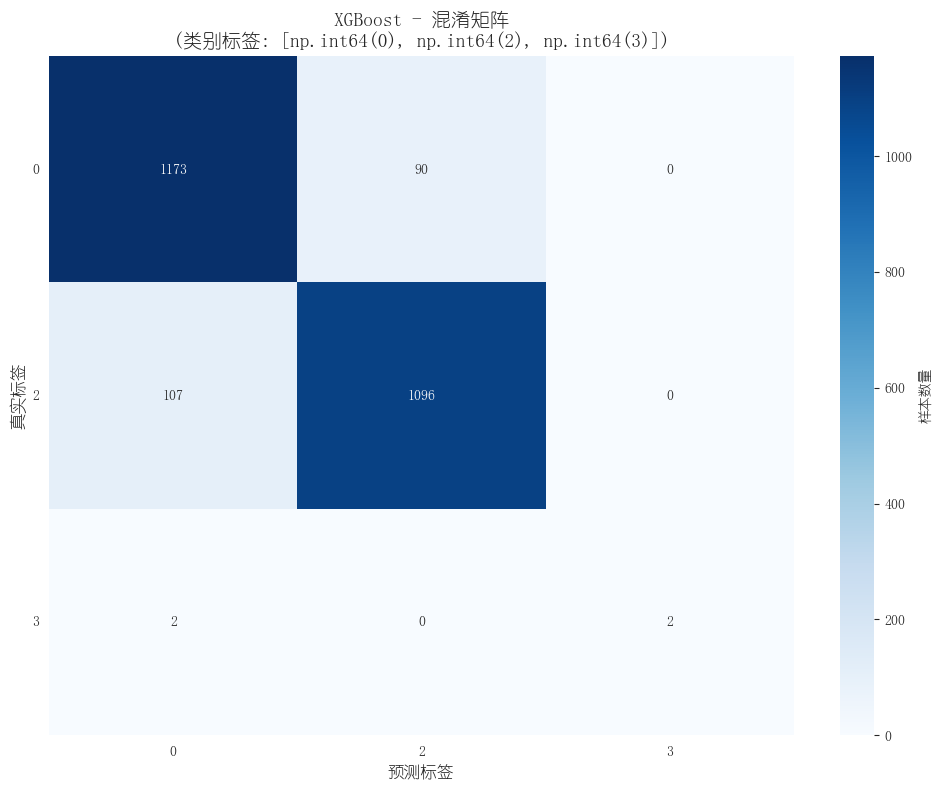

超参数调整后混淆矩阵：

实际类别标签: [np.int64(0), np.int64(2), np.int64(3)]

混淆矩阵 (数值格式):
       预测: 0  预测: 2  预测: 3
真实: 0   1179     84      0
真实: 2    113   1090      0
真实: 3      1      0      3


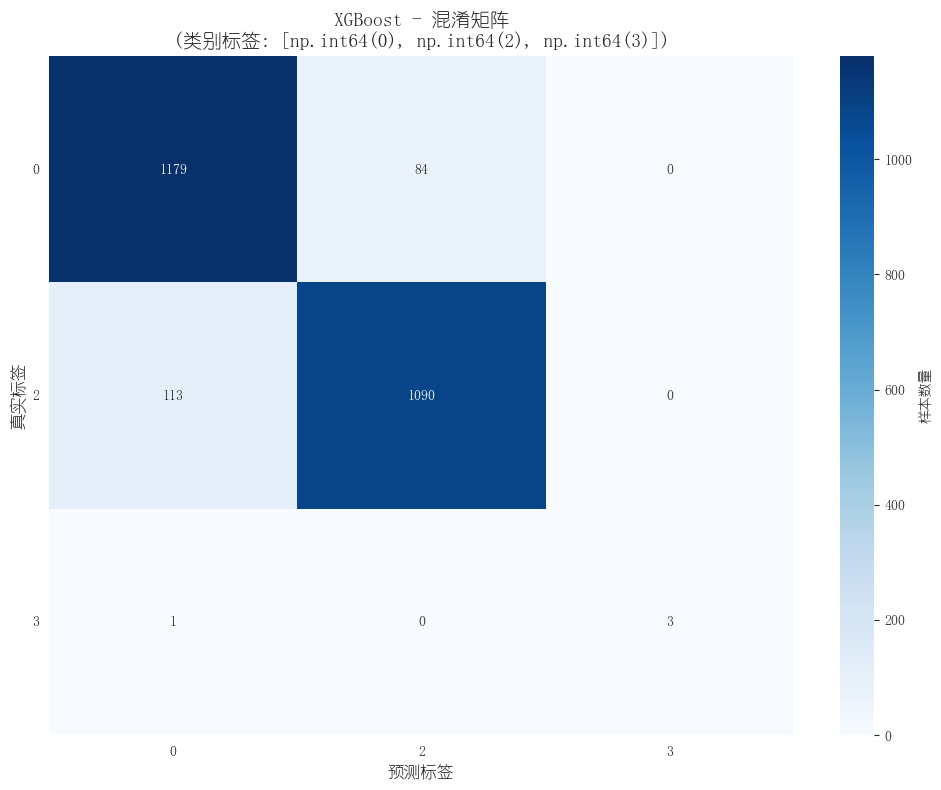

In [22]:
# 选择最佳模型
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']
basic_best_predictions=basic_results[best_model_name]['predictions']
print(f"\n最佳模型: {best_model_name}")
print("=" * 50)

# 详细分类报告
print("详细分类报告:")
print(classification_report(y_test, best_predictions))

def cm_to_show(y_test,best_predictions,best_model_name):
    '''
    绘制混淆矩阵，因为用的是XGBoost，需要考虑类别变换
    '''
    if best_model_name=="XGBoost":
        labels = sorted(np.unique(np.concatenate([y_test, best_predictions])))
        print(f"实际类别标签: {labels}")
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, best_predictions, labels=labels)

    # 将混淆矩阵转换为DataFrame，便于显示
    cm_df = pd.DataFrame(cm, 
                     index=[f'真实: {label}' for label in labels],
                     columns=[f'预测: {label}' for label in labels])

    print("\n混淆矩阵 (数值格式):")
    print(cm_df)

    # 可视化混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': '样本数量'})

    plt.title(f'{best_model_name} - 混淆矩阵\n(类别标签: {labels})', fontsize=14, fontweight='bold')
    plt.ylabel('真实标签', fontsize=12)
    plt.xlabel('预测标签', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("超参数调整前混淆矩阵：\n")
cm_to_show(y_test,basic_best_predictions,best_model_name)
print("超参数调整后混淆矩阵：\n")
cm_to_show(y_test,best_predictions,best_model_name)


调超参数反而让模型在0类的表现更差，但是由于在3类上表现更好，模型的最终准确率更高

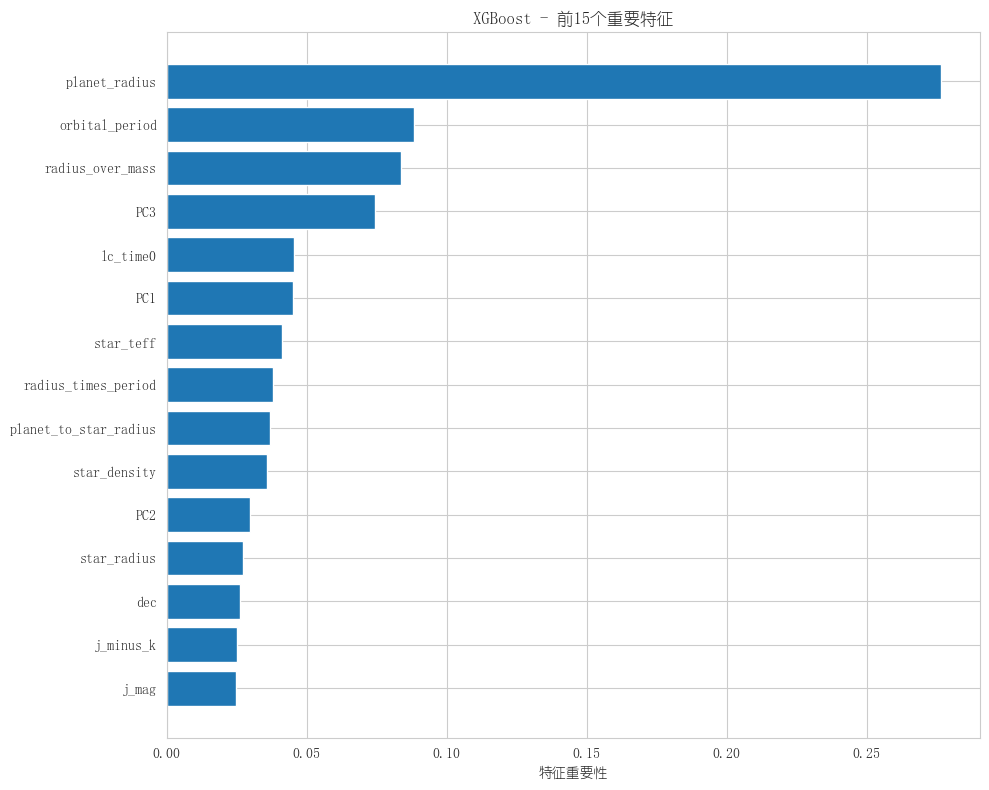

前10个最重要特征:
                  feature  importance
7           planet_radius    0.276572
8          orbital_period    0.088374
19       radius_over_mass    0.083490
2                     PC3    0.074316
13               lc_time0    0.045460
0                     PC1    0.045183
9               star_teff    0.041044
18    radius_times_period    0.038022
14  planet_to_star_radius    0.036890
15           star_density    0.035642


In [21]:
# 如果最佳模型是树模型，分析特征重要性
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['feature'][:15], 
             feature_importance['importance'][:15])
    plt.xlabel('特征重要性')
    plt.title(f'{best_model_name} - 前15个重要特征')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("前10个最重要特征:")
    print(feature_importance.head(10))

## 带权重调整的版本

最优模型性能展示

1. 检查各结果集并找出最佳模型
--------------------------------------------------------------------------------
✅ 基础模型（权重调整）最佳: XGBoost, 准确率: 0.9194
✅ 超参数调优（权重调整）最佳: XGBoost, 准确率: 0.9211

2. 所有最优模型性能对比
--------------------------------------------------------------------------------
                 模型类型  测试准确率            CV准确率
超参数调优（权重调整） - XGBoost 0.9211 0.9076 (±0.0022)
 基础模型（权重调整） - XGBoost 0.9194 0.9019 (±0.0014)

🎯 全局最佳模型: 超参数调优（权重调整） - XGBoost
📊 全局最佳准确率: 0.9211

3. 全局最佳模型详细评估
模型类型: 超参数调优（权重调整） - XGBoost
模型对象: XGBClassifier

详细分类报告:
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1263
           2       0.93      0.91      0.92      1203
           3       1.00      0.75      0.86         4

    accuracy                           0.92      2470
   macro avg       0.95      0.86      0.90      2470
weighted avg       0.92      0.92      0.92      2470


各类别详细表现:
--------

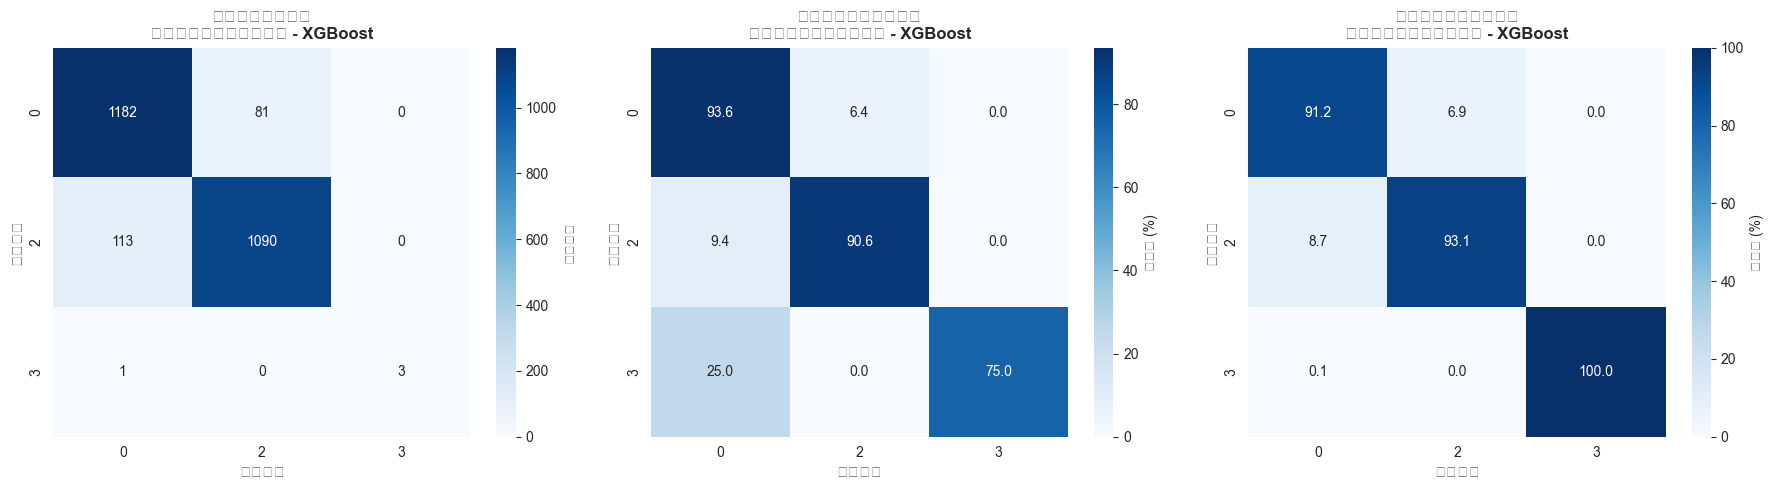


5. 错误分析
--------------------------------------------------------------------------------
总样本数: 2470
错误分类数: 195
错误率: 7.89%

最常见的错误类型（前10个）:
----------------------------------------
  真实类别 2 → 预测类别 0: 113 次 (9.4% 的真实类别 2 样本)
  真实类别 0 → 预测类别 2: 81 次 (6.4% 的真实类别 0 样本)
  真实类别 3 → 预测类别 0: 1 次 (25.0% 的真实类别 3 样本)

各类别错误率分析:
----------------------------------------
  类别 0: 错误率 6.4%, 最常误判为类别 2 (81/81 个错误)
  类别 2: 错误率 9.4%, 最常误判为类别 0 (113/113 个错误)
  类别 3: 错误率 25.0%, 最常误判为类别 0 (1/1 个错误)

最优模型性能展示完成!


In [25]:
# 设置中文字体和图表样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
print("=" * 80)
print("最优模型性能展示")
print("=" * 80)

# 1. 首先检查各个结果集是否存在，并找出每个结果集的最佳模型
print("\n1. 检查各结果集并找出最佳模型")
print("-" * 80)

all_best_models = {}

# 检查并找出basic_results_的最佳模型
if 'basic_results_' in globals() and basic_results_:
    basic_best_name = None
    basic_best_acc = -1
    
    for name, result in basic_results_.items():
        if result.get('model') is not None and result.get('accuracy', 0) > basic_best_acc:
            basic_best_acc = result['accuracy']
            basic_best_name = name
    
    if basic_best_name:
        all_best_models[f'基础模型（权重调整） - {basic_best_name}'] = {
            'result_set': 'basic_results_',
            'model_name': basic_best_name,
            'model': basic_results_[basic_best_name]['model'],
            'predictions': basic_results_[basic_best_name]['predictions'],
            'accuracy': basic_best_acc,
            'cv_mean': basic_results_[basic_best_name]['cv_mean'],
            'cv_std': basic_results_[basic_best_name]['cv_std']
        }
        print(f"✅ 基础模型（权重调整）最佳: {basic_best_name}, 准确率: {basic_best_acc:.4f}")

# 检查并找出results的最佳模型
if 'results' in globals() and results:
    results_best_name = None
    results_best_acc = -1
    
    for name, result in results.items():
        if result.get('model') is not None and result.get('accuracy', 0) > results_best_acc:
            results_best_acc = result['accuracy']
            results_best_name = name
    
    if results_best_name:
        all_best_models[f'超参数调优（原始） - {results_best_name}'] = {
            'result_set': 'results',
            'model_name': results_best_name,
            'model': results[results_best_name]['model'],
            'predictions': results[results_best_name]['predictions'],
            'accuracy': results_best_acc,
            'cv_mean': results[results_best_name]['cv_mean'],
            'cv_std': results[results_best_name]['cv_std']
        }
        print(f"✅ 超参数调优（原始）最佳: {results_best_name}, 准确率: {results_best_acc:.4f}")

# 检查并找出results_weighted_的最佳模型
if 'results_weighted_' in globals() and results_weighted_:
    weighted_best_name = None
    weighted_best_acc = -1
    
    for name, result in results_weighted_.items():
        if result.get('model') is not None and result.get('accuracy', 0) > weighted_best_acc:
            weighted_best_acc = result['accuracy']
            weighted_best_name = name
    
    if weighted_best_name:
        all_best_models[f'超参数调优（权重调整） - {weighted_best_name}'] = {
            'result_set': 'results_weighted_',
            'model_name': weighted_best_name,
            'model': results_weighted_[weighted_best_name]['model'],
            'predictions': results_weighted_[weighted_best_name]['predictions'],
            'accuracy': weighted_best_acc,
            'cv_mean': results_weighted_[weighted_best_name]['cv_mean'],
            'cv_std': results_weighted_[weighted_best_name]['cv_std']
        }
        print(f"✅ 超参数调优（权重调整）最佳: {weighted_best_name}, 准确率: {weighted_best_acc:.4f}")

if not all_best_models:
    print("❌ 未找到任何训练结果，请先运行模型训练代码")
    exit()

# 2. 创建性能对比表格
print("\n2. 所有最优模型性能对比")
print("-" * 80)

comparison_data = []
for display_name, model_info in all_best_models.items():
    comparison_data.append({
        '模型类型': display_name,
        '测试准确率': f"{model_info['accuracy']:.4f}",
        'CV准确率': f"{model_info['cv_mean']:.4f} (±{model_info['cv_std']:.4f})"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('测试准确率', key=lambda x: x.str.replace('±.*', '').astype(float), ascending=False)
print(comparison_df.to_string(index=False))

# 找出全局最佳模型
global_best_name = max(all_best_models.items(), key=lambda x: x[1]['accuracy'])[0]
global_best_info = all_best_models[global_best_name]
print(f"\n🎯 全局最佳模型: {global_best_name}")
print(f"📊 全局最佳准确率: {global_best_info['accuracy']:.4f}")

# 3. 显示全局最佳模型的详细分类报告和混淆矩阵
print("\n3. 全局最佳模型详细评估")
print("=" * 80)

# 获取真实标签和预测标签
y_true = y_test
y_pred_best = global_best_info['predictions']

# 确保y_true和y_pred_best长度一致
if len(y_true) != len(y_pred_best):
    print(f"⚠️  警告: 真实标签({len(y_true)})与预测标签({len(y_pred_best)})长度不一致")
    # 尝试对齐索引
    if isinstance(y_pred_best, pd.Series):
        y_pred_best = y_pred_best.loc[y_true.index]
    elif isinstance(y_pred_best, np.ndarray):
        y_pred_best = pd.Series(y_pred_best, index=y_true.index)

print(f"模型类型: {global_best_name}")
print(f"模型对象: {type(global_best_info['model']).__name__}")

# 分类报告
print("\n详细分类报告:")
print("-" * 60)
print(classification_report(y_true, y_pred_best))

# 解析分类报告以获得更多信息
report_dict = classification_report(y_true, y_pred_best, output_dict=True)

print("\n各类别详细表现:")
print("-" * 60)
for label in sorted([k for k in report_dict.keys() if k.isdigit() or (k.replace('.', '').isdigit() and '.' in k)]):
    label_int = int(float(label))
    precision = report_dict[label]['precision']
    recall = report_dict[label]['recall']
    f1 = report_dict[label]['f1-score']
    support = report_dict[label]['support']
    
    # 获取该类别在训练集中的数量
    train_support = np.sum(y_train == label_int) if 'y_train' in globals() else "N/A"
    
    print(f"类别 {label_int}:")
    print(f"  训练集样本数: {train_support}")
    print(f"  测试集样本数: {support}")
    print(f"  精确率 (Precision): {precision:.3f}")
    print(f"  召回率 (Recall): {recall:.3f}")
    print(f"  F1分数: {f1:.3f}")
    
    

# 4. 混淆矩阵可视化
print("\n4. 混淆矩阵可视化")
print("-" * 80)

# 获取所有类别标签
labels_all = sorted(np.unique(np.concatenate([y_true, y_pred_best])))

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred_best, labels=labels_all)

# 创建子图：原始混淆矩阵和归一化混淆矩阵
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 子图1：原始混淆矩阵（计数）
ax1 = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_all, yticklabels=labels_all,
            cbar_kws={'label': '样本数量'},
            ax=ax1)
ax1.set_title(f'混淆矩阵（计数）\n{global_best_name}', fontsize=12, fontweight='bold')
ax1.set_ylabel('真实标签', fontsize=11)
ax1.set_xlabel('预测标签', fontsize=11)

# 子图2：行归一化混淆矩阵（百分比）
ax2 = axes[1]
cm_row_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_row_norm = np.round(cm_row_norm * 100, 1)

sns.heatmap(cm_row_norm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=labels_all, yticklabels=labels_all,
            cbar_kws={'label': '百分比 (%)'},
            ax=ax2)
ax2.set_title(f'混淆矩阵（行百分比）\n{global_best_name}', fontsize=12, fontweight='bold')
ax2.set_ylabel('真实标签', fontsize=11)
ax2.set_xlabel('预测标签', fontsize=11)

# 子图3：列归一化混淆矩阵（百分比）
ax3 = axes[2]
cm_col_norm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
cm_col_norm = np.round(cm_col_norm * 100, 1)

sns.heatmap(cm_col_norm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=labels_all, yticklabels=labels_all,
            cbar_kws={'label': '百分比 (%)'},
            ax=ax3)
ax3.set_title(f'混淆矩阵（列百分比）\n{global_best_name}', fontsize=12, fontweight='bold')
ax3.set_ylabel('真实标签', fontsize=11)
ax3.set_xlabel('预测标签', fontsize=11)

plt.tight_layout()
plt.show()

# 5. 错误分析
print("\n5. 错误分析")
print("-" * 80)

# 找出错误分类的样本
wrong_mask = y_true != y_pred_best
wrong_count = wrong_mask.sum()
total_count = len(y_true)

print(f"总样本数: {total_count}")
print(f"错误分类数: {wrong_count}")
print(f"错误率: {wrong_count/total_count:.2%}")

if wrong_count > 0:
    # 分析最常见的错误类型
    error_types = {}
    for true_label in labels_all:
        for pred_label in labels_all:
            if true_label != pred_label:
                count = np.sum((y_true == true_label) & (y_pred_best == pred_label))
                if count > 0:
                    error_types[(true_label, pred_label)] = count
    
    print(f"\n最常见的错误类型（前10个）:")
    print("-" * 40)
    
    # 按错误数量排序
    sorted_errors = sorted(error_types.items(), key=lambda x: x[1], reverse=True)[:10]
    
    for (true_label, pred_label), count in sorted_errors:
        # 计算该类错误的占比
        true_class_total = np.sum(y_true == true_label)
        error_percentage = count / true_class_total * 100 if true_class_total > 0 else 0
        
        print(f"  真实类别 {true_label} → 预测类别 {pred_label}: {count} 次 ({error_percentage:.1f}% 的真实类别 {true_label} 样本)")
    
    # 分析每个类别的错误率
    print(f"\n各类别错误率分析:")
    print("-" * 40)
    
    for label in labels_all:
        class_mask = y_true == label
        class_total = class_mask.sum()
        if class_total > 0:
            class_wrong = np.sum((y_true == label) & (y_true != y_pred_best))
            class_error_rate = class_wrong / class_total * 100
            
            # 找出该类别最常被误判为什么类别
            if class_wrong > 0:
                common_misclass = {}
                for pred_label in labels_all:
                    if pred_label != label:
                        misclass_count = np.sum((y_true == label) & (y_pred_best == pred_label))
                        if misclass_count > 0:
                            common_misclass[pred_label] = misclass_count
                
                if common_misclass:
                    most_common = max(common_misclass.items(), key=lambda x: x[1])
                    print(f"  类别 {label}: 错误率 {class_error_rate:.1f}%, 最常误判为类别 {most_common[0]} ({most_common[1]}/{class_wrong} 个错误)")
                else:
                    print(f"  类别 {label}: 错误率 {class_error_rate:.1f}%")
            else:
                print(f"  类别 {label}: 完美分类 (0% 错误率)")

    


print("\n" + "=" * 80)
print("最优模型性能展示完成!")
print("=" * 80)

# 保存结果：

In [23]:
from datetime import datetime
import joblib
import json


def save_model_results_joblib(results_dict, basic_results_dict, save_dir='model_results'):
    """
    使用joblib保存模型结果（对大模型更高效）
    
    参数:
    results_dict: 调优后的结果字典
    basic_results_dict: 调优前的结果字典
    save_dir: 保存目录
    """
    
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'models'), exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. 保存模型对象（使用joblib）
    models_info = {}
    
    for model_name, model_info in results_dict.items():
        if 'model' in model_info:
            model = model_info['model']
            model_path = os.path.join(save_dir, 'models', f"{model_name}_{timestamp}.joblib")
            joblib.dump(model, model_path)
            models_info[model_name] = model_path
    
    # 2. 保存结果数据（不含模型对象，使用JSON/CSV）
    results_data = {}
    for model_name, model_info in results_dict.items():
        results_data[model_name] = {
            'accuracy': float(model_info.get('accuracy', 0)),
            'cv_mean': float(model_info.get('cv_mean', 0)),
            'cv_std': float(model_info.get('cv_std', 0)),
            'best_params': model_info.get('best_params', {}),
            'model_path': models_info.get(model_name, '')
        }
    
    basic_results_data = {}
    for model_name, model_info in basic_results_dict.items():
        basic_results_data[model_name] = {
            'accuracy': float(model_info.get('accuracy', 0)),
            'cv_mean': float(model_info.get('cv_mean', 0)),
            'cv_std': float(model_info.get('cv_std', 0))
        }
    
    # 保存为JSON
    json_data = {
        'results': results_data,
        'basic_results': basic_results_data,
        'timestamp': timestamp,
        'model_paths': models_info
    }
    
    json_path = os.path.join(save_dir, f'model_results_{timestamp}.json')
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(json_data, f, ensure_ascii=False, indent=2)
    
    print(f" JSON结果已保存到: {json_path}")
    
    # 3. 创建性能对比表格
    performance_data = []
    
    all_models = set(list(results_dict.keys()) + list(basic_results_dict.keys()))
    
    for model_name in all_models:
        row = {'模型名称': model_name}
        
        if model_name in basic_results_dict:
            basic = basic_results_dict[model_name]
            row['调优前准确率'] = basic.get('accuracy')
            row['调优前CV均值'] = basic.get('cv_mean')
        
        if model_name in results_dict:
            result = results_dict[model_name]
            row['调优后准确率'] = result.get('accuracy')
            row['调优后CV均值'] = result.get('cv_mean')
            row['是否调优'] = '是'
            
            # 如果有最佳参数，添加到行
            best_params = result.get('best_params')
            if best_params:
                for param, value in best_params.items():
                    row[f'最佳_{param}'] = value
        else:
            row['是否调优'] = '否'
        
        performance_data.append(row)
    
    # 保存为CSV
    df_performance = pd.DataFrame(performance_data)
    csv_path = os.path.join(save_dir, f'performance_comparison_{timestamp}.csv')
    df_performance.to_csv(csv_path, index=False, encoding='utf-8-sig')
    
    print(f" 性能对比表格已保存到: {csv_path}")
    
    # 4. 创建汇总报告
    report_path = os.path.join(save_dir, f'summary_report_{timestamp}.txt')
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("模型结果保存汇总\n")
        f.write("=" * 60 + "\n")
        f.write(f"保存时间: {timestamp}\n")
        f.write(f"保存目录: {save_dir}\n\n")
        
        f.write("已保存的模型文件:\n")
        for model_name, model_path in models_info.items():
            f.write(f"  {model_name}: {model_path}\n")
        
        f.write(f"\n总共保存了 {len(models_info)} 个模型对象\n")
    
    print(f" 汇总报告已保存到: {report_path}")
    
    return {
        'json_results': json_path,
        'csv_performance': csv_path,
        'summary_report': report_path,
        'model_paths': models_info
    }

# 使用示例
if __name__ == "__main__":
    saved_files = save_model_results_joblib(results, basic_results)
    
    print("\n 所有文件保存完成:")
    for file_type, file_path in saved_files.items():
        if file_type != 'model_paths':
            print(f"  {file_type}: {file_path}")
    
    print("\n 已保存的模型:")
    for model_name, model_path in saved_files['model_paths'].items():
        print(f"  {model_name}: {model_path}")

 JSON结果已保存到: model_results\model_results_20251202_114238.json
 性能对比表格已保存到: model_results\performance_comparison_20251202_114238.csv
 汇总报告已保存到: model_results\summary_report_20251202_114238.txt

 所有文件保存完成:
  json_results: model_results\model_results_20251202_114238.json
  csv_performance: model_results\performance_comparison_20251202_114238.csv
  summary_report: model_results\summary_report_20251202_114238.txt

 已保存的模型:
  Random Forest: model_results\models\Random Forest_20251202_114238.joblib
  Gradient Boosting: model_results\models\Gradient Boosting_20251202_114238.joblib
  XGBoost: model_results\models\XGBoost_20251202_114238.joblib


# 将训练出来的模型应用于类别1，进行分类尝试

In [34]:
# 1. 复制原始数据，避免修改原数据
ML_ready_new = ML_ready.copy()

print(f"原始数据形状: {ML_ready.shape}")
print(f"类别1的样本数量: {len(ML_ready[ML_ready['label'] == 1])}")
print(f"所有类别分布:")
print(ML_ready['label'].value_counts().sort_index())

# 2. 提取原标签为1的样本进行预测
X_new = ML_ready[ML_ready['label'] == 1].drop('label', axis=1)
print(f"\n待预测的样本数量: {X_new.shape[0]}")

# 检查是否存在无限大值
if X_new.select_dtypes(include=[np.number]).applymap(np.isinf).sum().sum() > 0:
    print("警告: 待预测数据中存在无穷大值，需要进行处理")
    # 清理无穷大值（使用训练时的相同处理方式）
    X_new_clean = X_new.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
    print("已清理无穷大值")
else:
    X_new_clean = X_new

# 3. 使用最佳模型进行预测
best_model = results[best_model_name]['model']
print(f"\n使用模型: {best_model_name}")

y_pred_new_xgb = best_model.predict(X_new_clean)
y_pred_new=np.array([reverse_mapping[label] for label in y_pred_new_xgb])

# 4. 查看预测结果分布
print("\n预测结果分布:")
unique_preds, counts = np.unique(y_pred_new, return_counts=True)
for pred, count in zip(unique_preds, counts):
    print(f"  预测为类别 {pred}: {count} 个样本 ({count/X_new.shape[0]*100:.1f}%)")

# 5. 更新ML_ready_new中的标签
# 找到原标签为1的样本的索引
indices_to_update = ML_ready_new[ML_ready_new['label'] == 1].index

# 使用.loc确保正确更新
ML_ready_new.loc[indices_to_update, 'label'] = y_pred_new

print(f"\n更新完成!")
print(f"更新后的数据形状: {ML_ready_new.shape}")
print(f"更新后的类别分布:")
print(ML_ready_new['label'].value_counts().sort_index())

# 原类别1的样本预测情况
original_label_1_indices = indices_to_update
original_label_1_predictions = y_pred_new

# 统计预测结果
prediction_counts = pd.Series(original_label_1_predictions).value_counts().sort_index()

print(f"原类别1的 {len(original_label_1_predictions)} 个样本被重新预测为:")
for pred_label, count in prediction_counts.items():
    percentage = count / len(original_label_1_predictions) * 100
    print(f"  类别 {pred_label}: {count} 个 ({percentage:.1f}%)")

# 9. 保存结果到文件
print("\n" + "="*50)
print("保存结果")
print("="*50)

import os
from datetime import datetime

# 创建保存目录
save_dir = 'updated_results'
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 保存更新后的数据
updated_file = os.path.join(save_dir, f'ML_ready_updated_{timestamp}.csv')
ML_ready_new.to_csv(updated_file, index=False, encoding='utf-8-sig')
print(f"✅ 更新后的数据已保存到: {updated_file}")

# 保存预测详情
prediction_details = pd.DataFrame({
    'original_index': list(original_label_1_indices),
    'original_label': [1] * len(original_label_1_indices),
    'predicted_label': original_label_1_predictions
})

details_file = os.path.join(save_dir, f'prediction_details_{timestamp}.csv')
prediction_details.to_csv(details_file, index=False, encoding='utf-8-sig')
print(f"✅ 预测详情已保存到: {details_file}")

# 返回更新后的数据
ML_ready_new = ML_ready_new

原始数据形状: (19761, 21)
类别1的样本数量: 7413
所有类别分布:
label
0    6311
1    7413
2    6015
3      22
Name: count, dtype: int64

待预测的样本数量: 7413

使用模型: XGBoost

预测结果分布:
  预测为类别 0: 3750 个样本 (50.6%)
  预测为类别 2: 3662 个样本 (49.4%)
  预测为类别 3: 1 个样本 (0.0%)

更新完成!
更新后的数据形状: (19761, 21)
更新后的类别分布:
label
0    10061
2     9677
3       23
Name: count, dtype: int64
原类别1的 7413 个样本被重新预测为:
  类别 0: 3750 个 (50.6%)
  类别 2: 3662 个 (49.4%)
  类别 3: 1 个 (0.0%)

保存结果
✅ 更新后的数据已保存到: updated_results\ML_ready_updated_20251202_120202.csv
✅ 预测详情已保存到: updated_results\prediction_details_20251202_120202.csv


# 另一个尝试：调整分类模型架构，先分出1和0，2，3，再分0，2，3

1. 方案可行性分析
优势与合理性：
问题分解：将复杂的四分类问题拆解为1个二分类+1个三分类，简化了每个子问题的复杂度

针对性优化：

第一层：专注于区分类别1与其他类别

第二层：专注于区分类别0、2、3

潜在提升点：如果类别1有独特的特征模式，单独训练模型可能提高对它的识别能力

模块化设计：便于针对不同层次进行特定优化（如不同的特征工程、模型选择）

风险与挑战：
错误传播风险：第一层的错误会直接传播到第二层

样本分配不平衡：训练第二层模型时，类别0、2、3的样本比例可能与原始分布不同

类别1的样本量：如果类别1样本太少，第一层模型可能过拟合

特征相关性：区分类别1的特征可能与区分类别0、2、3的特征不同

数据验证（基于你的分类报告）：
原始数据：类别0(1263)、类别2(1203)、类别3(4)

类别1样本量：未知（从你的代码推测存在类别1需要重新预测）

关键问题：类别3只有4个样本，第二层的三分类问题将面临极度不平衡

建议改进点：
对第一层使用重采样技术处理不平衡

对第二层考虑类别加权或专门处理类别3的少量样本

考虑使用预测概率而非硬分类，设置合理阈值

In [9]:
print("=" * 60)
print("步骤1：数据准备与分割")
print("=" * 60)

# 分离特征和标签
X_ = ML_ready.drop('label', axis=1)
y_ = ML_ready['label']

# 分层分割训练集和测试集
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_, y_, 
    test_size=0.2, 
    random_state=42,
    stratify=y_  # 保持类别比例
)

print(f"\n训练集: {X_train_.shape[0]} 个样本")
print(f"测试集: {X_test_.shape[0]} 个样本")
print("\n训练集标签分布:")
print(y_train_.value_counts().sort_index())
print("\n测试集标签分布:")
print(y_test_.value_counts().sort_index())

# 可选：特征标准化（根据之前代码，某些模型需要）
scaler_ = StandardScaler()
X_train_scaled_ = scaler_.fit_transform(X_train_)
X_test_scaled_ = scaler_.transform(X_test_)
X_train_scaled_ = pd.DataFrame(X_train_scaled_, columns=X_train_.columns)
X_test_scaled_ = pd.DataFrame(X_test_scaled_, columns=X_test_.columns)

print("\n✅ 数据分割完成")

步骤1：数据准备与分割

训练集: 15808 个样本
测试集: 3952 个样本

训练集标签分布:
label
0    5049
1    5930
2    4811
3      18
Name: count, dtype: int64

测试集标签分布:
label
0    1262
1    1483
2    1203
3       4
Name: count, dtype: int64

✅ 数据分割完成


In [10]:
print("\n" + "=" * 60)
print("步骤2：第一层模型训练（二分类：1 vs 非1）")
print("=" * 60)

# 创建第一层的二分类标签
y_train_layer1_ = (y_train_ == 1).astype(int)  # 1->1, 其他->0
y_test_layer1_ = (y_test_ == 1).astype(int)

print(f"第一层标签分布 (训练集):")
print(pd.Series(y_train_layer1_).value_counts().sort_index())
print(f"类别1占比: {y_train_layer1_.mean():.2%}")

# 根据类别比例计算样本权重
# 如果类别1很少，需要给更高权重


# 选择第一层模型（可以选择二分类表现好的模型）
# 这里以XGBoost为例，你也可以选择其他
layer1_model_ = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=len(y_train_layer1_[y_train_layer1_==0])/len(y_train_layer1_[y_train_layer1_==1]),
    n_estimators=100,
    max_depth=5
)

# 训练第一层模型
print("\n训练第一层模型...")
layer1_model_.fit(X_train_, y_train_layer1_)

# 在训练集上评估
y_train_pred_layer1_ = layer1_model_.predict(X_train_)
train_acc_layer1_ = accuracy_score(y_train_layer1_, y_train_pred_layer1_)
print(f"第一层模型训练集准确率: {train_acc_layer1_:.4f}")

# 交叉验证
cv_scores_layer1_ = cross_val_score(layer1_model_, X_train_, y_train_layer1_, cv=5, scoring='accuracy')
print(f"第一层模型交叉验证准确率: {cv_scores_layer1_.mean():.4f} (±{cv_scores_layer1_.std():.4f})")

# 详细评估
print("\n第一层模型详细分类报告:")
print(classification_report(y_train_layer1_, y_train_pred_layer1_, target_names=['非1', '1']))

print("\n✅ 第一层模型训练完成")


步骤2：第一层模型训练（二分类：1 vs 非1）
第一层标签分布 (训练集):
label
0    9878
1    5930
Name: count, dtype: int64
类别1占比: 37.51%

训练第一层模型...
第一层模型训练集准确率: 0.9067
第一层模型交叉验证准确率: 0.7963 (±0.0058)

第一层模型详细分类报告:
              precision    recall  f1-score   support

          非1       0.96      0.89      0.92      9878
           1       0.83      0.94      0.88      5930

    accuracy                           0.91     15808
   macro avg       0.90      0.91      0.90     15808
weighted avg       0.91      0.91      0.91     15808


✅ 第一层模型训练完成


In [11]:
print("\n" + "=" * 60)
print("步骤3：准备第二层训练数据（类别0、2、3）")
print("=" * 60)

# 使用第一层模型预测训练集
train_probs_layer1_ = layer1_model_.predict_proba(X_train_)[:, 1]  # 预测为1的概率

# 设置阈值（可调整）
threshold_ = 0.5  # 可以调整为更保守的值，如0.3

# 获取第一层预测为非1的训练样本（用于第二层训练）
mask_non1_ = train_probs_layer1_ < threshold_

X_train_layer2_ = X_train_[mask_non1_]
y_train_layer2_ = y_train_[mask_non1_]

print(f"第二层训练数据:")
print(f"  原始训练集: {len(X_train_)} 个样本")
print(f"  第二层训练集: {len(X_train_layer2_)} 个样本")
print(f"  过滤掉: {len(X_train_) - len(X_train_layer2_)} 个被预测为1的样本")

print(f"\n第二层标签分布:")
layer2_dist_ = y_train_layer2_.value_counts().sort_index()
for label, count in layer2_dist_.items():
    print(f"  类别 {label}: {count} 个样本 ({count/len(y_train_layer2_):.1%})")

# 处理类别不平衡：类别3样本极少
if 3 in y_train_layer2_.value_counts():
    class_3_count_ = y_train_layer2_.value_counts()[3]
    if class_3_count_ < 10:
        print(f"⚠️  警告: 类别3只有 {class_3_count_} 个样本，第二层训练可能困难")
        
print("\n✅ 第二层训练数据准备完成")


步骤3：准备第二层训练数据（类别0、2、3）
第二层训练数据:
  原始训练集: 15808 个样本
  第二层训练集: 9083 个样本
  过滤掉: 6725 个被预测为1的样本

第二层标签分布:
  类别 0: 4505 个样本 (49.6%)
  类别 1: 340 个样本 (3.7%)
  类别 2: 4224 个样本 (46.5%)
  类别 3: 14 个样本 (0.2%)

✅ 第二层训练数据准备完成


In [13]:
from sklearn.preprocessing import LabelEncoder

print("\n" + "=" * 60)
print("步骤4：第二层模型训练（三分类：0、2、3）")
print("=" * 60)

# 为第二层训练准备：只保留类别0、2、3
valid_labels_ = [0, 2, 3]
mask_valid_labels_ = y_train_layer2_.isin(valid_labels_)

X_train_layer2_filtered_ = X_train_layer2_[mask_valid_labels_]
y_train_layer2_filtered_ = y_train_layer2_[mask_valid_labels_]

print(f"过滤后的第二层训练数据:")
print(f"  过滤前: {len(X_train_layer2_)} 个样本")
print(f"  过滤后: {len(X_train_layer2_filtered_)} 个样本")
print(f"  移除了 {len(X_train_layer2_) - len(X_train_layer2_filtered_)} 个非0/2/3类别的样本")

print(f"\n过滤后的标签分布:")
for label in valid_labels_:
    count = (y_train_layer2_filtered_ == label).sum()
    print(f"  类别 {label}: {count} 个样本")

# 由于XGBoost需要连续标签，进行映射
label_mapping_ = {0: 0, 2: 1, 3: 2}
reverse_mapping_ = {v: k for k, v in label_mapping_.items()}

y_train_layer2_mapped_ = y_train_layer2_filtered_.map(label_mapping_)

# 计算类别权重（处理不平衡）
from sklearn.utils.class_weight import compute_class_weight
classes_ = sorted(y_train_layer2_mapped_.unique())
classes_np_ = np.array(classes_)
weights_ = compute_class_weight('balanced', classes=classes_np_, y=y_train_layer2_mapped_)
class_weights_layer2_ = dict(zip(classes_np_, weights_))

print(f"\n类别权重: {class_weights_layer2_}")

# 选择第二层模型
layer2_model_ = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    num_class=len(valid_labels_),
    objective='multi:softprob',
    n_estimators=100,
    max_depth=5
)

# 训练第二层模型
print("\n训练第二层模型...")
layer2_model_.fit(X_train_layer2_filtered_, y_train_layer2_mapped_)

# 在训练集上评估
y_train_pred_layer2_mapped_ = layer2_model_.predict(X_train_layer2_filtered_)
y_train_pred_layer2_ = pd.Series(y_train_pred_layer2_mapped_).map(reverse_mapping_)

train_acc_layer2_ = accuracy_score(y_train_layer2_filtered_, y_train_pred_layer2_)
print(f"第二层模型训练集准确率: {train_acc_layer2_:.4f}")

# 详细评估
print("\n第二层模型详细分类报告:")
print(classification_report(y_train_layer2_filtered_, y_train_pred_layer2_))

print("\n✅ 第二层模型训练完成")


步骤4：第二层模型训练（三分类：0、2、3）
过滤后的第二层训练数据:
  过滤前: 9083 个样本
  过滤后: 8743 个样本
  移除了 340 个非0/2/3类别的样本

过滤后的标签分布:
  类别 0: 4505 个样本
  类别 2: 4224 个样本
  类别 3: 14 个样本

类别权重: {np.int64(0): np.float64(0.6469108398076212), np.int64(1): np.float64(0.6899463383838383), np.int64(2): np.float64(208.16666666666666)}

训练第二层模型...
第二层模型训练集准确率: 0.9906

第二层模型详细分类报告:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4505
           2       1.00      0.98      0.99      4224
           3       1.00      1.00      1.00        14

    accuracy                           0.99      8743
   macro avg       0.99      0.99      0.99      8743
weighted avg       0.99      0.99      0.99      8743


✅ 第二层模型训练完成


In [14]:
print("\n" + "=" * 60)
print("步骤5：在测试集上应用两层分类器")
print("=" * 60)

# 步骤5.1：第一层预测
print("第一步: 第一层预测 (1 vs 非1)")
test_probs_layer1_ = layer1_model_.predict_proba(X_test_)[:, 1]
test_pred_layer1_ = (test_probs_layer1_ >= threshold_).astype(int)

print(f"第一层预测为1的样本数: {test_pred_layer1_.sum()}")
print(f"第一层预测为非1的样本数: {len(test_pred_layer1_) - test_pred_layer1_.sum()}")

# 步骤5.2：第二层预测（对非1样本）
print("\n第二步: 第二层预测 (对非1样本进行0/2/3分类)")
mask_non1_test_ = test_pred_layer1_ == 0
X_test_non1_ = X_test_[mask_non1_test_]

if len(X_test_non1_) > 0:
    # 预测第二层
    test_pred_layer2_mapped_ = layer2_model_.predict(X_test_non1_)
    test_pred_layer2_ = pd.Series(test_pred_layer2_mapped_).map(reverse_mapping_)
    
    print(f"第二层预测样本数: {len(X_test_non1_)}")
    print(f"第二层预测分布:")
    for label in valid_labels_:
        count = (test_pred_layer2_ == label).sum()
        print(f"  类别 {label}: {count} 个样本")
else:
    print("⚠️  警告: 第一层将所有测试样本都预测为1，没有样本进入第二层")
    test_pred_layer2_ = pd.Series([], dtype=int)

# 步骤5.3：合并预测结果
print("\n第三步: 合并两层预测结果")
final_predictions_ = pd.Series(index=y_test_.index, dtype=int)

# 填充第一层的预测为1的样本
mask_1_ = test_pred_layer1_ == 1
if mask_1_.any():
    final_predictions_[mask_1_] = 1

# 填充第二层的预测结果
if len(test_pred_layer2_) > 0:
    # 注意：需要确保索引对齐
    final_predictions_[mask_non1_test_] = test_pred_layer2_.values

# 检查是否有未预测的样本
missing_indices_ = final_predictions_[final_predictions_.isna()].index
if len(missing_indices_) > 0:
    print(f"⚠️  警告: 有 {len(missing_indices_)} 个样本未被预测，使用多数类填充")
    # 使用训练集中最多的类别填充
    majority_class_ = y_train_.value_counts().idxmax()
    final_predictions_[missing_indices_] = majority_class_

# 确保所有测试样本都有预测
final_predictions_ = final_predictions_.astype(int)

print(f"最终预测完成，样本数: {len(final_predictions_)}")


步骤5：在测试集上应用两层分类器
第一步: 第一层预测 (1 vs 非1)
第一层预测为1的样本数: 1670
第一层预测为非1的样本数: 2282

第二步: 第二层预测 (对非1样本进行0/2/3分类)
第二层预测样本数: 2282
第二层预测分布:
  类别 0: 1212 个样本
  类别 2: 1067 个样本
  类别 3: 3 个样本

第三步: 合并两层预测结果
最终预测完成，样本数: 3952



步骤6：评估整体性能
两层分类器整体准确率: 0.7518

详细分类报告:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1262
           1       0.69      0.78      0.73      1483
           2       0.81      0.72      0.76      1203
           3       1.00      0.75      0.86         4

    accuracy                           0.75      3952
   macro avg       0.82      0.75      0.78      3952
weighted avg       0.76      0.75      0.75      3952



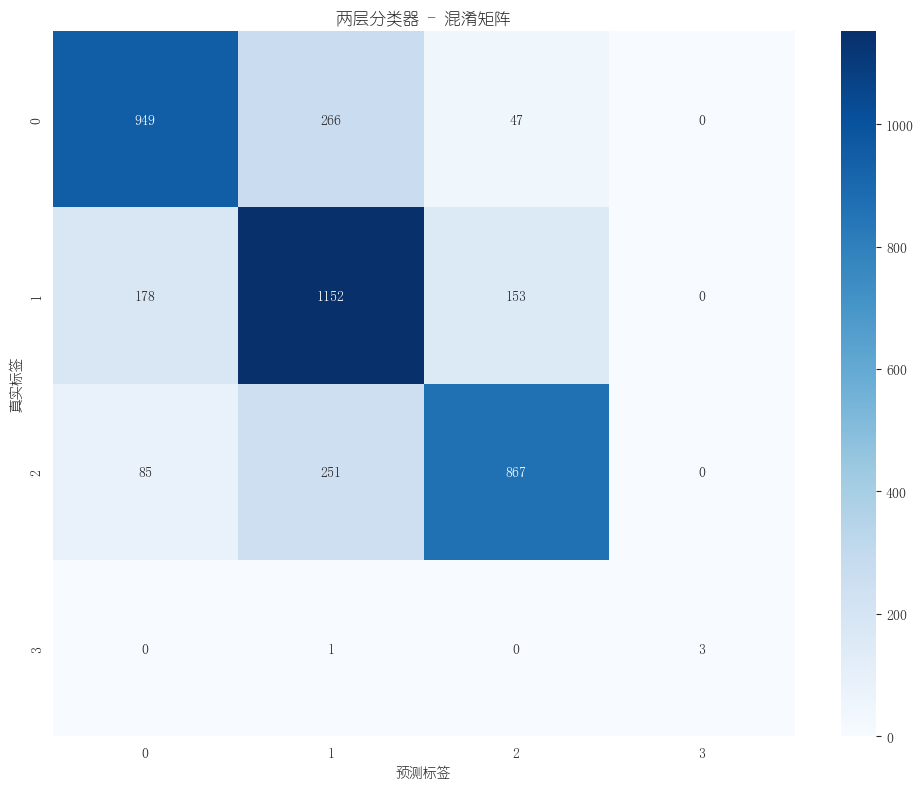


----------------------------------------
分层性能分析
----------------------------------------
第一层 (1 vs 非1) 表现:
              precision    recall  f1-score   support

          非1       0.85      0.79      0.82      2469
           1       0.69      0.78      0.73      1483

    accuracy                           0.79      3952
   macro avg       0.77      0.78      0.78      3952
weighted avg       0.79      0.79      0.79      3952


第二层 (仅对实际非1且预测为非1的样本) 表现:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       996
           2       0.95      0.91      0.93       952
           3       1.00      1.00      1.00         3

    accuracy                           0.93      1951
   macro avg       0.96      0.95      0.95      1951
weighted avg       0.93      0.93      0.93      1951


✅ 两层分类器评估完成


In [15]:
print("\n" + "=" * 60)
print("步骤6：评估整体性能")
print("=" * 60)

# 计算准确率
overall_accuracy_ = accuracy_score(y_test_, final_predictions_)
print(f"两层分类器整体准确率: {overall_accuracy_:.4f}")

# 与单层模型对比（假设有之前的最佳模型结果）
if 'results' in globals() and best_model_name in results:
    single_model_accuracy = results[best_model_name]['accuracy']
    improvement_ = overall_accuracy_ - single_model_accuracy
    print(f"单层最佳模型 ({best_model_name}) 准确率: {single_model_accuracy:.4f}")
    print(f"两层分类器相比单层模型: {improvement_:+.4f} ({improvement_/single_model_accuracy*100:+.1f}%)")

# 详细分类报告
print("\n详细分类报告:")
print(classification_report(y_test_, final_predictions_))

# 混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
labels_all_ = sorted(np.unique(np.concatenate([y_test_, final_predictions_])))
cm_ = confusion_matrix(y_test_, final_predictions_, labels=labels_all_)
sns.heatmap(cm_, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_all_, yticklabels=labels_all_)
plt.title('两层分类器 - 混淆矩阵')
plt.ylabel('真实标签')
plt.xlabel('预测标签')
plt.tight_layout()
plt.show()

# 分析每一层的表现
print("\n" + "-" * 40)
print("分层性能分析")
print("-" * 40)

# 第一层在测试集上的表现
print("第一层 (1 vs 非1) 表现:")
print(classification_report(y_test_layer1_, test_pred_layer1_, target_names=['非1', '1']))

# 第二层在测试集上的表现（只对实际非1的样本）
if mask_non1_test_.any():
    actual_non1_mask_ = y_test_ != 1
    second_layer_actual_non1_ = y_test_[actual_non1_mask_ & mask_non1_test_]
    second_layer_pred_non1_ = final_predictions_[actual_non1_mask_ & mask_non1_test_]
    
    if len(second_layer_actual_non1_) > 0:
        print("\n第二层 (仅对实际非1且预测为非1的样本) 表现:")
        print(classification_report(second_layer_actual_non1_, second_layer_pred_non1_))
    else:
        print("\n第二层: 没有实际非1且预测为非1的样本可用于评估")

print("\n✅ 两层分类器评估完成")

因此，某种程度上说，直接对整体分类效果不好就是因为candidate类的划分不好，candidate中某些元素事实上能够被划分，但他们处于1标签，这就严重干扰了分类

# 一些奇怪的想法

## MLP

多层感知机(MLP)分类器

 构建多层感知机(MLP)模型
--------------------------------------------------
类别数量: 4
基础MLP模型配置:
  隐藏层结构: (100, 50)
  激活函数: relu
  优化器: adam
  最大迭代次数: 300
  学习率: 0.001

6. 训练MLP模型
--------------------------------------------------
开始训练基础MLP模型...
训练完成!
最终迭代次数: 69
训练损失: 0.2516
是否因早停而终止: 是
损失曲线长度: 69

7. 模型评估
--------------------------------------------------
训练集准确率: 0.8931
测试集准确率: 0.8737

进行5折交叉验证...
交叉验证准确率: 0.8596 (±0.0087)

详细分类报告:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1263
           2       0.88      0.86      0.87      1203
           3       0.00      0.00      0.00         4

    accuracy                           0.87      2470
   macro avg       0.58      0.58      0.58      2470
weighted avg       0.87      0.87      0.87      2470


8. 混淆矩阵可视化
--------------------------------------------------


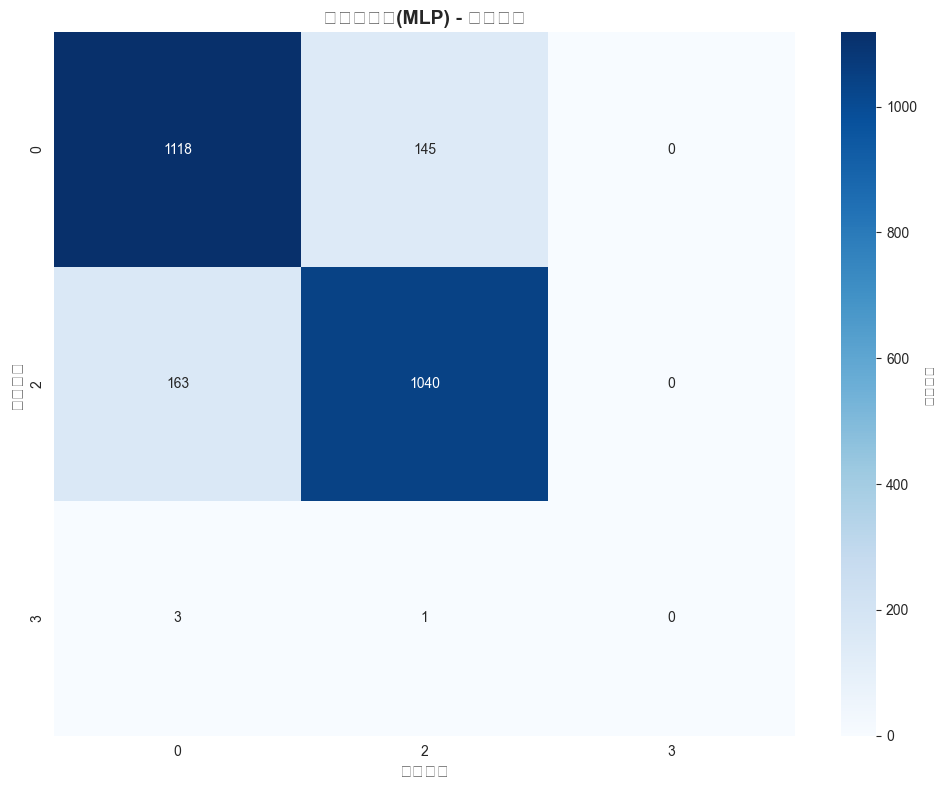


9. 训练过程可视化
--------------------------------------------------


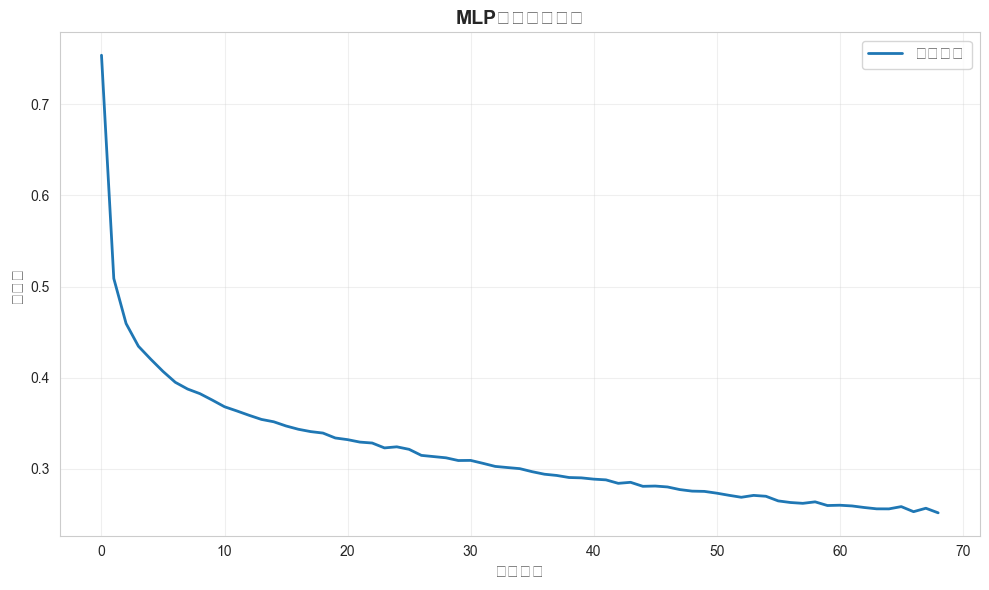

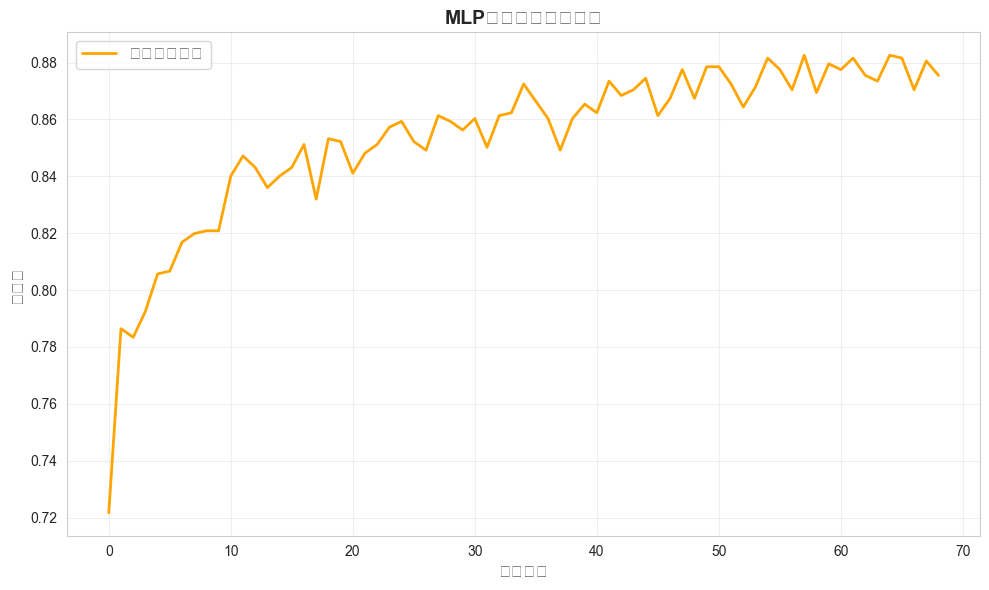

In [17]:
from sklearn.neural_network import MLPClassifier

print("=" * 80)
print("多层感知机(MLP)分类器")
print("=" * 80)

# 5. 构建MLP模型
print("\n 构建多层感知机(MLP)模型")
print("-" * 50)

# 获取类别数量
n_classes = len(np.unique(y))
print(f"类别数量: {n_classes}")

# 创建基础MLP模型
mlp_basic = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # 两层隐藏层：100个神经元和50个神经元
    activation='relu',  # 使用ReLU激活函数
    solver='adam',  # 使用Adam优化器
    alpha=0.0001,  # L2正则化参数
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=300,
    random_state=42,
    early_stopping=True,  # 使用早停防止过拟合
    validation_fraction=0.1,  # 验证集比例
    n_iter_no_change=10,  # 早停耐心值
    verbose=False
)

print("基础MLP模型配置:")
print(f"  隐藏层结构: {mlp_basic.hidden_layer_sizes}")
print(f"  激活函数: {mlp_basic.activation}")
print(f"  优化器: {mlp_basic.solver}")
print(f"  最大迭代次数: {mlp_basic.max_iter}")
print(f"  学习率: {mlp_basic.learning_rate_init}")

# 6. 训练模型
print("\n6. 训练MLP模型")
print("-" * 50)

print("开始训练基础MLP模型...")
mlp_basic.fit(X_train_scaled, y_train)

print("训练完成!")
print(f"最终迭代次数: {mlp_basic.n_iter_}")
print(f"训练损失: {mlp_basic.loss_:.4f}")
print(f"是否因早停而终止: {'是' if mlp_basic.n_iter_ < mlp_basic.max_iter else '否'}")

# 查看训练历史（如果有的话）
if hasattr(mlp_basic, 'loss_curve_'):
    print(f"损失曲线长度: {len(mlp_basic.loss_curve_)}")

# 7. 模型评估
print("\n7. 模型评估")
print("-" * 50)

# 在训练集上评估
y_train_pred_mlp = mlp_basic.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred_mlp)
print(f"训练集准确率: {train_accuracy:.4f}")

# 在测试集上评估
y_test_pred_mlp = mlp_basic.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred_mlp)
print(f"测试集准确率: {test_accuracy:.4f}")

# 交叉验证
print("\n进行5折交叉验证...")
cv_scores_mlp = cross_val_score(mlp_basic, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"交叉验证准确率: {cv_scores_mlp.mean():.4f} (±{cv_scores_mlp.std():.4f})")

# 详细分类报告
print("\n详细分类报告:")
print(classification_report(y_test, y_test_pred_mlp))

# 8. 混淆矩阵可视化
print("\n8. 混淆矩阵可视化")
print("-" * 50)

plt.figure(figsize=(10, 8))
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
labels_all = sorted(np.unique(np.concatenate([y_test, y_test_pred_mlp])))

sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels_all, yticklabels=labels_all,
            cbar_kws={'label': '样本数量'})

plt.title('多层感知机(MLP) - 混淆矩阵', fontsize=14, fontweight='bold')
plt.ylabel('真实标签', fontsize=12)
plt.xlabel('预测标签', fontsize=12)
plt.tight_layout()
plt.show()

# 9. 损失曲线可视化（如果有的话）
print("\n9. 训练过程可视化")
print("-" * 50)

if hasattr(mlp_basic, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(mlp_basic.loss_curve_, label='训练损失', linewidth=2)
    plt.title('MLP训练损失曲线', fontsize=14, fontweight='bold')
    plt.xlabel('迭代次数', fontsize=12)
    plt.ylabel('损失值', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    if hasattr(mlp_basic, 'validation_scores_'):
        plt.figure(figsize=(10, 6))
        plt.plot(mlp_basic.validation_scores_, label='验证集准确率', linewidth=2, color='orange')
        plt.title('MLP验证集准确率曲线', fontsize=14, fontweight='bold')
        plt.xlabel('迭代次数', fontsize=12)
        plt.ylabel('准确率', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.show()
else:
    print("未记录损失曲线，无法可视化训练过程")


In [21]:

# 10. 超参数调优（可选）
print("\n10. 超参数调优（简化版）")
print("-" * 50)

# 创建调优的MLP模型
print("开始超参数调优...")

# 定义参数网格（简化版，避免过长时间训练）
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh','sigmoid'],
    'alpha': [0.0001, 0.001,0.01,0.1],
    'learning_rate_init': [0.0001,0.001, 0.01,0.1]
}

# 创建MLP分类器用于调优
mlp_tune = MLPClassifier(
    solver='adam',
    max_iter=200,
    random_state=42,
    early_stopping=True,
    verbose=False
)

# 使用网格搜索（使用较小的搜索空间）
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    mlp_tune, param_grid, 
    cv=5,  # 使用5折交叉验证以加快速度
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("正在进行网格搜索...")
grid_search.fit(X_train_scaled, y_train)

print("网格搜索完成!")
print(f"最佳参数: {grid_search.best_params_}")
print(f"最佳交叉验证准确率: {grid_search.best_score_:.4f}")

# 使用最佳模型
best_mlp = grid_search.best_estimator_

# 在测试集上评估最佳模型
y_test_pred_best = best_mlp.predict(X_test_scaled)
best_test_accuracy = accuracy_score(y_test, y_test_pred_best)
print(f"最佳模型测试集准确率: {best_test_accuracy:.4f}")

# 与基础模型对比
improvement = best_test_accuracy - test_accuracy
print(f"调优后提升: {improvement:+.4f}")


10. 超参数调优（简化版）
--------------------------------------------------
开始超参数调优...
正在进行网格搜索...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
网格搜索完成!
最佳参数: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01}
最佳交叉验证准确率: 0.8732
最佳模型测试集准确率: 0.8850
调优后提升: +0.0113


## 降维后看一下

=== 数据准备 ===
数据集形状: (19760, 21)
标签列唯一值: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
标签分布:
label
1    7413
0    6311
2    6014
3      22
Name: count, dtype: int64

特征列数量: 20
标准化特征数据...
执行t-SNE降维...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19760 samples in 0.001s...
[t-SNE] Computed neighbors for 19760 samples in 1.294s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19760
[t-SNE] Computed conditional probabilities for sample 2000 / 19760
[t-SNE] Computed conditional probabilities for sample 3000 / 19760
[t-SNE] Computed conditional probabilities for sample 4000 / 19760
[t-SNE] Computed conditional probabilities for sample 5000 / 19760
[t-SNE] Computed conditional probabilities for sample 6000 / 19760
[t-SNE] Computed conditional probabilities for sample 7000 / 19760
[t-SNE] Computed conditional probabilities for sample 8000 / 19760
[t-SNE] Computed conditional probabilities for sample 9000 / 19760
[t-SNE] Computed conditional probabilities for s

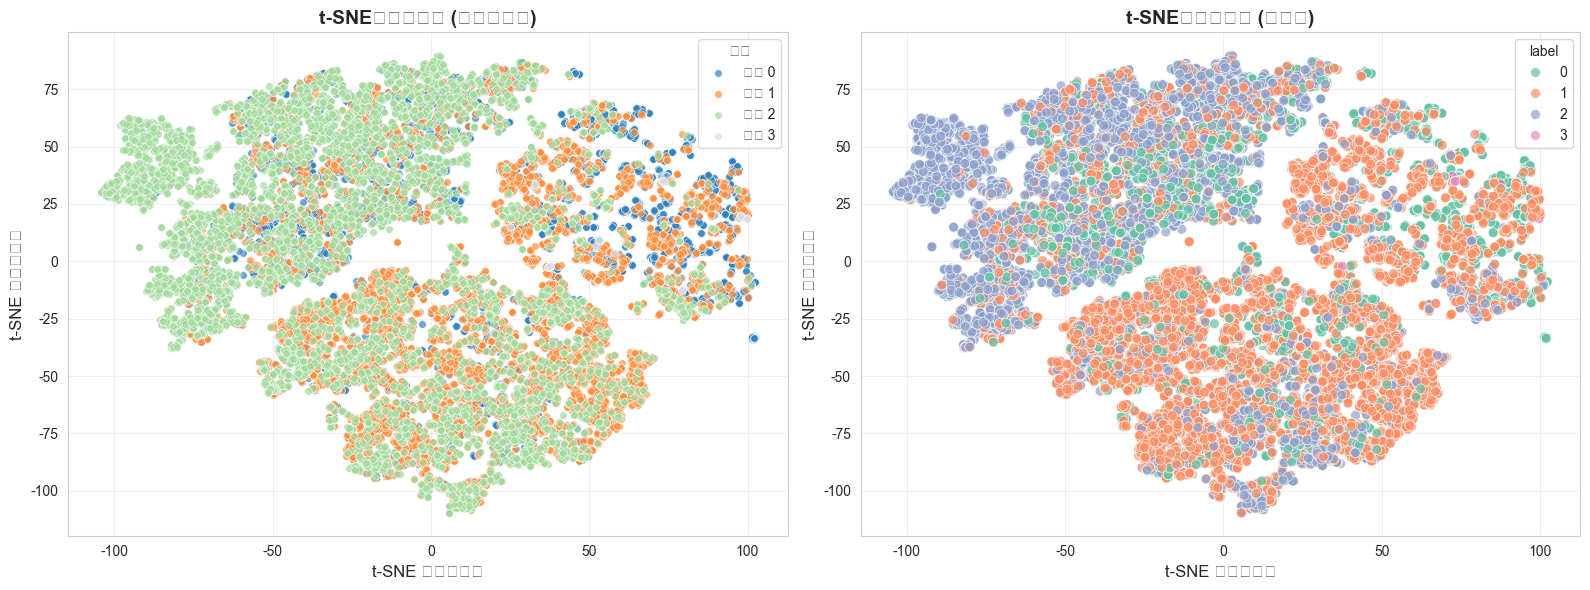

降维结果已保存为 'tSNE_result.csv'

=== t-SNE降维分析 ===

各标签在t-SNE空间中的中心位置:
标签 0: 中心位置(14.65, 16.28), 标准差(47.61, 40.69)
标签 1: 中心位置(10.03, -20.22), 标准差(40.30, 44.85)
标签 2: 中心位置(-29.89, 6.96), 标准差(45.03, 50.07)
标签 3: 中心位置(64.93, 11.63), 标准差(24.65, 16.33)

类别间距离分析:
类别中心点距离矩阵:
类别 0: ['0.00', '36.79', '45.51', '50.49']
类别 1: ['36.79', '0.00', '48.29', '63.47']
类别 2: ['45.51', '48.29', '0.00', '94.93']
类别 3: ['50.49', '63.47', '94.93', '0.00']

是否要创建3D t-SNE可视化图？(y/n)
执行3D t-SNE降维...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19760 samples in 0.001s...
[t-SNE] Computed neighbors for 19760 samples in 0.321s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19760
[t-SNE] Computed conditional probabilities for sample 2000 / 19760
[t-SNE] Computed conditional probabilities for sample 3000 / 19760
[t-SNE] Computed conditional probabilities for sample 4000 / 19760
[t-SNE] Computed conditional probabilities for sample 5000 / 19760
[t-SNE] Computed conditional probabilities for sa

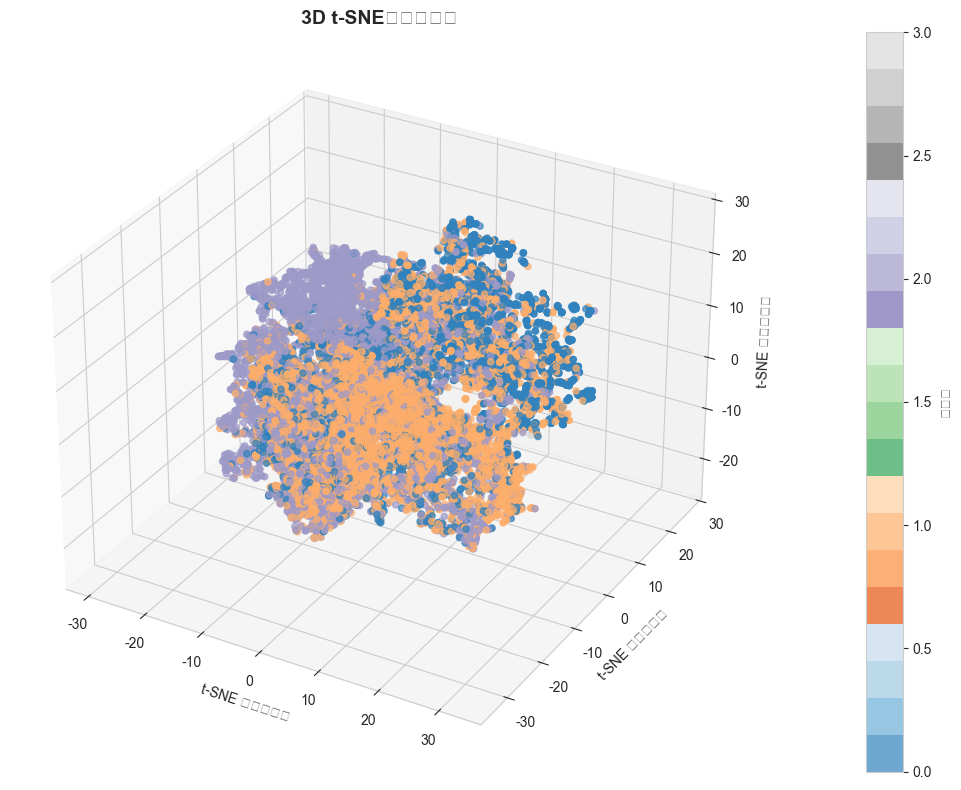

In [16]:

from sklearn.manifold import TSNE


# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
sns.set_style("whitegrid")

# 1. 准备数据
print("=== 数据准备 ===")

# 检查数据中是否有label列
if 'label' not in ML_ready.columns:
    print("错误：数据集中没有找到'label'列")
    print("请检查数据集的列名：", ML_ready.columns.tolist())
else:
    print(f"数据集形状: {ML_ready.shape}")
    print(f"标签列唯一值: {sorted(ML_ready['label'].unique())}")
    print(f"标签分布:\n{ML_ready['label'].value_counts()}")
    
    # 2. 分离特征和标签
    # 找出所有特征列（除了label以外的所有列）
    feature_columns = [col for col in ML_ready.columns if col != 'label']
    print(f"\n特征列数量: {len(feature_columns)}")
    
    # 提取特征数据和标签
    X = ML_ready[feature_columns].values
    y = ML_ready['label'].values
    
    # 3. 标准化特征数据（t-SNE对尺度敏感，建议标准化）
    print("标准化特征数据...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 4. t-SNE降维
    print("执行t-SNE降维...")
    
    # 设置t-SNE参数
    n_components = 2  # 降到2维
    perplexity = min(30, X_scaled.shape[0] - 1)  # perplexity值，不能大于样本数-1
    n_iter = 1000  # 迭代次数
    random_state = 42  # 随机种子，确保可重复性
    
    # 创建t-SNE模型
    tsne = TSNE(n_components=n_components, 
                perplexity=perplexity, 
                n_iter=n_iter,
                random_state=random_state,
                verbose=1)  # 显示进度信息
    
    # 执行降维
    X_tsne = tsne.fit_transform(X_scaled)
    
    print(f"降维完成！原始维度: {X_scaled.shape}, 降维后: {X_tsne.shape}")
    
    # 5. 创建结果DataFrame
    tsne_df = pd.DataFrame({
        'tSNE1': X_tsne[:, 0],
        'tSNE2': X_tsne[:, 1],
        'label': y
    })
    
    # 6. 可视化
    print("创建可视化图形...")
    
    # 创建图形
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 子图1：按标签着色的散点图
    ax1 = axes[0]
    
    # 获取唯一的标签和颜色映射
    unique_labels = np.unique(y)
    n_labels = len(unique_labels)
    
    # 使用tab20c色图，支持更多类别
    if n_labels <= 20:
        cmap = plt.cm.tab20c
    else:
        cmap = plt.cm.gist_ncar  # 对于超过20个类别，使用更丰富的色图
    
    # 为每个标签创建颜色映射
    label_to_color = {}
    for i, label in enumerate(sorted(unique_labels)):
        label_to_color[label] = cmap(i / max(n_labels, 1))
    
    # 绘制每个标签的数据点
    for label in unique_labels:
        mask = y == label
        ax1.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   c=[label_to_color[label]], 
                   label=f'类别 {label}', 
                   alpha=0.7, 
                   s=30,
                   edgecolors='w', 
                   linewidth=0.5)
    
    ax1.set_title('t-SNE降维可视化 (按标签着色)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE 第一主成分', fontsize=12)
    ax1.set_ylabel('t-SNE 第二主成分', fontsize=12)
    ax1.legend(title='标签', fontsize=10, title_fontsize=11, 
               loc='best', framealpha=0.7)
    ax1.grid(True, alpha=0.3)
    
    # 子图2：使用seaborn的hue参数绘制，更简洁
    ax2 = axes[1]
    
    # 如果标签数量不多，使用seaborn的散点图
    if n_labels <= 10:
        sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='label', 
                       palette='Set2', s=50, alpha=0.7, ax=ax2)
    else:
        # 标签太多时，简化显示
        scatter = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
                             cmap='viridis', alpha=0.7, s=30)
        plt.colorbar(scatter, ax=ax2, label='标签值')
    
    ax2.set_title('t-SNE降维可视化 (简化版)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('t-SNE 第一主成分', fontsize=12)
    ax2.set_ylabel('t-SNE 第二主成分', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # 7. 保存图形
    plt.savefig('tSNE_visualization.png', dpi=300, bbox_inches='tight')
    print("图形已保存为 'tSNE_visualization.png'")
    
    # 8. 显示图形
    plt.show()
    
    # 9. 保存降维后的数据
    # 将降维结果与原始数据合并（可选）
    tsne_result_df = pd.DataFrame(X_tsne, columns=['tSNE_component_1', 'tSNE_component_2'])
    tsne_result_df['label'] = y
    
    # 保存为CSV文件
    tsne_result_df.to_csv('tSNE_result.csv', index=False)
    print("降维结果已保存为 'tSNE_result.csv'")
    
    # 10. 分析降维效果
    print("\n=== t-SNE降维分析 ===")
    
    # 计算每个标签的t-SNE坐标统计信息
    print("\n各标签在t-SNE空间中的中心位置:")
    for label in unique_labels:
        mask = y == label
        center_x = X_tsne[mask, 0].mean()
        center_y = X_tsne[mask, 1].mean()
        std_x = X_tsne[mask, 0].std()
        std_y = X_tsne[mask, 1].std()
        print(f"标签 {label}: 中心位置({center_x:.2f}, {center_y:.2f}), "
              f"标准差({std_x:.2f}, {std_y:.2f})")
    
    # 计算类别间的平均距离
    if n_labels > 1:
        print("\n类别间距离分析:")
        from scipy.spatial.distance import cdist
        
        # 计算每个类别的中心点
        centers = []
        for label in unique_labels:
            mask = y == label
            center = X_tsne[mask].mean(axis=0)
            centers.append(center)
        
        centers = np.array(centers)
        
        # 计算中心点之间的距离矩阵
        dist_matrix = cdist(centers, centers)
        
        print("类别中心点距离矩阵:")
        for i, label_i in enumerate(unique_labels):
            row = [f"{dist_matrix[i, j]:.2f}" for j in range(len(unique_labels))]
            print(f"类别 {label_i}: {row}")
    
    # 11. 可选：3D t-SNE可视化（如果需要）
    # 询问是否进行3D可视化
    print("\n是否要创建3D t-SNE可视化图？(y/n)")
    response = input().strip().lower()
    
    if response == 'y':
        from mpl_toolkits.mplot3d import Axes3D
        
        # 3D t-SNE降维
        print("执行3D t-SNE降维...")
        tsne_3d = TSNE(n_components=3, 
                      perplexity=perplexity, 
                      n_iter=n_iter,
                      random_state=random_state,
                      verbose=1)
        
        X_tsne_3d = tsne_3d.fit_transform(X_scaled)
        
        # 创建3D图形
        fig_3d = plt.figure(figsize=(12, 8))
        ax_3d = fig_3d.add_subplot(111, projection='3d')
        
        # 绘制3D散点图
        scatter_3d = ax_3d.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2],
                                  c=y, cmap='tab20c', alpha=0.7, s=20)
        
        ax_3d.set_title('3D t-SNE降维可视化', fontsize=14, fontweight='bold')
        ax_3d.set_xlabel('t-SNE 第一主成分')
        ax_3d.set_ylabel('t-SNE 第二主成分')
        ax_3d.set_zlabel('t-SNE 第三主成分')
        
        # 添加颜色条
        cbar = plt.colorbar(scatter_3d, ax=ax_3d, pad=0.1)
        cbar.set_label('标签值')
        
        plt.tight_layout()
        plt.savefig('tSNE_3d_visualization.png', dpi=300, bbox_inches='tight')
        print("3D图形已保存为 'tSNE_3d_visualization.png'")
        plt.show()